In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from loguru import logger
import numpy as np
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


In [3]:
import tomllib
configfile = Path("../config.toml").resolve()
with configfile.open("rb") as f:
    config = tomllib.load(f)

datafile = (Path("..") / Path(config["processed"]) / config["current"]).resolve()


if not datafile.exists():
    logger.warning("Datafile does not exist. First run src/preprocess.py, and check the timestamp!")
df = pd.read_parquet(datafile)
df.head()

,timestamp,message,author,has_emoji,language,date,isoweek,year-week,hour,topic,year,age,message_length,log_len,emoij_status
0,2019-11-05 17:16:00,Ik eet vanavond niet thuis,effervescent-camel,False,NL,2019-11-05,45,2019-44,17,kom thuis,2019,17,26,3.258097,Without Emoji
1,2021-09-03 15:50:00,Ik weet niet of het kan als je geen bedrijf hebt,hilarious-goldfinch,False,NL,2021-09-03,35,2021-35,15,kom thuis,2021,49,48,3.871201,Without Emoji
2,2021-09-06 17:08:00,Ik eet niet thuis,effervescent-camel,False,NL,2021-09-06,36,2021-36,17,kom thuis,2021,19,17,2.833213,Without Emoji
3,2021-09-27 15:05:00,Ik ben trouwens vanavond na het eten thuis,effervescent-camel,False,NL,2021-09-27,39,2021-39,15,kom thuis,2021,19,42,3.737670,Without Emoji
4,2021-09-30 19:13:00,Hoe laat eet je mee,nimble-wombat,False,NL,2021-09-30,39,2021-39,19,kom thuis,2021,50,19,2.944439,Without Emoji


In [438]:
def convert_to_decimal_hours(timestamp):
    dec_hour = timestamp.hour + timestamp.minute / 60 + timestamp.second / 3600
    return dec_hour




In [439]:
datafile = "../data/processed/whatsapp-20240916-104455.parq"
df = pd.read_parquet(datafile)
#df.head()

In [440]:
df["hour"] = df["timestamp"].apply(convert_to_decimal_hours)
df["log_len"] = df["message_length"].apply(lambda x: np.log(x))
dob_mapping = {'effervescent-camel': 2002, 'nimble-wombat':1971, 'hilarious-goldfinch':1972,
       'spangled-rabbit':2004}
df['dob'] = df['author'].map(dob_mapping)


In [441]:
#include age in the features (cleanup stage)
df['year'] = df["timestamp"].apply(lambda x: x.year)
df['age'] = df['year']-df['dob']
df.drop(['dob'], inplace=True, axis=1)

In [444]:
def convert_to_decimal_hours(timestamp):
    dec_hour = timestamp.hour + timestamp.minute / 60 + timestamp.second / 3600
    return dec_hour

df["hour"] = df["timestamp"].apply(convert_to_decimal_hours)
df["log_len"] = df["message_length"].apply(lambda x: np.log(x))
#df.head()


In [445]:
df_with_emoji =df[df['has_emoji']]
df_withou_emoji =df[df['has_emoji']==False]

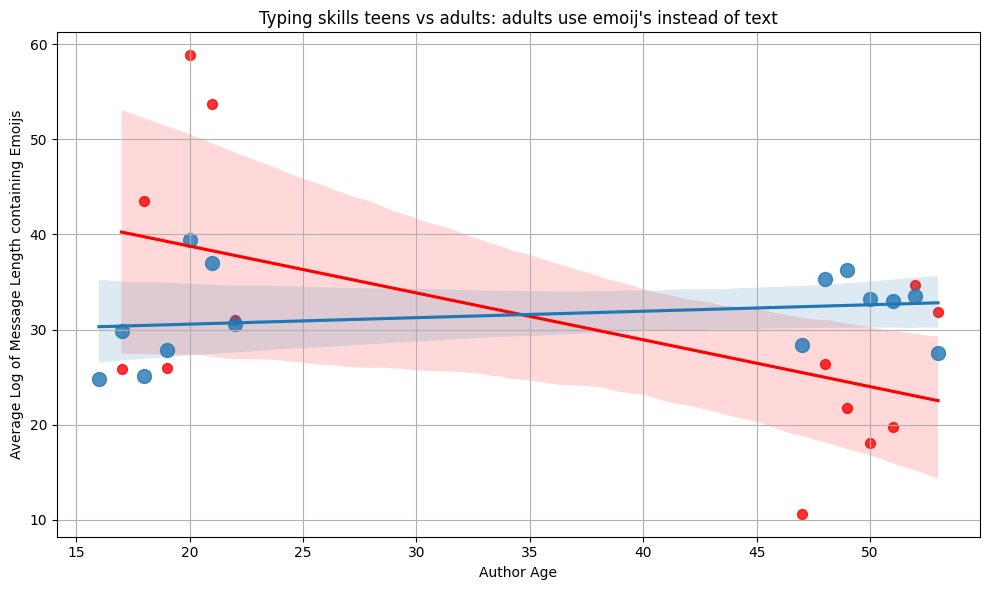

In [418]:
# Calculate the logarithm of message length
df['log_len'] = np.log(df['message_length'])

# Calculate the average log length per author
avg_log_length_withemoji = df_em.groupby('age')['message_length'].mean().reset_index()
avg_log_length_without_emoji = df_nem.groupby('age')['message_length'].mean().reset_index()

# Create the regression plot
plt.figure(figsize=(10, 6), facecolor='white')

# Regression line for average log length against age
sns.regplot(data=avg_log_length_withemoji, x='age', y='message_length', marker='o', scatter_kws={'s': 50}, color='red')
sns.regplot(data=avg_log_length_without_emoji, x='age', y='message_length', marker='o', scatter_kws={'s': 100})

# Add titles and labels
plt.title("Typing skills teens vs adults: adults use emoij's instead of text")
plt.xlabel('Author Age')
plt.ylabel('Average Log of Message Length containing Emoijs')
plt.xticks()
plt.grid()

# Adjust layout
plt.tight_layout()

# Save the plot
plt.savefig('average_log_length_vs_age.png', bbox_inches='tight', transparent=False)

# Show the plot
plt.show()

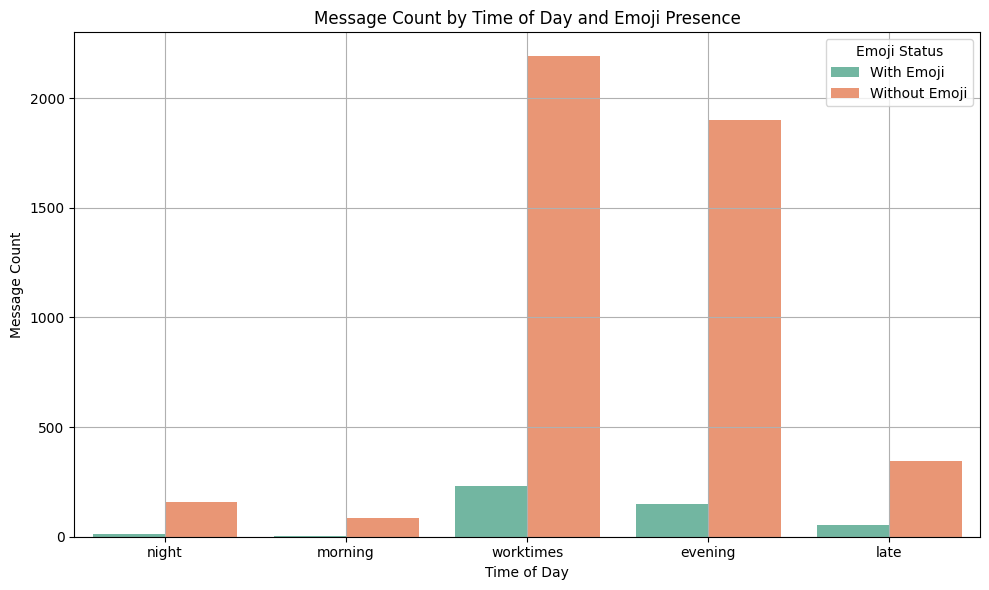

In [248]:

# Create a new column for emoji presence
df['emoji_status'] = df['has_emoji'].apply(lambda x: 'With Emoji' if x > 0 else 'Without Emoji')

# Step 1: Count occurrences for each combination of time of day and emoji presence
count_data = df.groupby(['timestamp_category', 'emoji_status']).size().reset_index(name='count')

# Step 2: Create the bar plot
plt.figure(figsize=(10, 6))
sns.barplot(data=count_data, x='timestamp_category', y='count', hue='emoji_status', palette='Set2')
plt.title('Message Count by Time of Day and Emoji Presence')
plt.xlabel('Time of Day')
plt.ylabel('Message Count')
plt.legend(title='Emoji Status')
plt.grid(True)
plt.tight_layout()

# Save the plot with an opaque background
plt.savefig('bar_plot_time_of_day_emoji.png', bbox_inches='tight', transparent=False)

# Show the plot
plt.show()


,message_length,has_emoji,count
author,,,
effervescent-camel,36.190370,0.041433,1786
hilarious-goldfinch,32.304574,0.102911,962
nimble-wombat,31.136683,0.147488,1851
spangled-rabbit,23.223464,0.013035,537


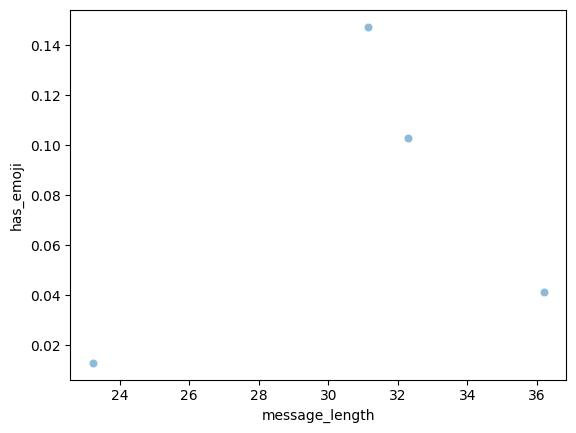

In [352]:
p = df.groupby(["author"]).agg({
    "message_length": "mean",
    "has_emoji": "mean",
    "author": "count"
    
}).rename(columns={"author": "count"})

p = p[p["count"] > 10]
sns.scatterplot(data=p, x="message_length", y="has_emoji", alpha=0.5)
p

<Axes: xlabel='message_length', ylabel='has_emoji'>

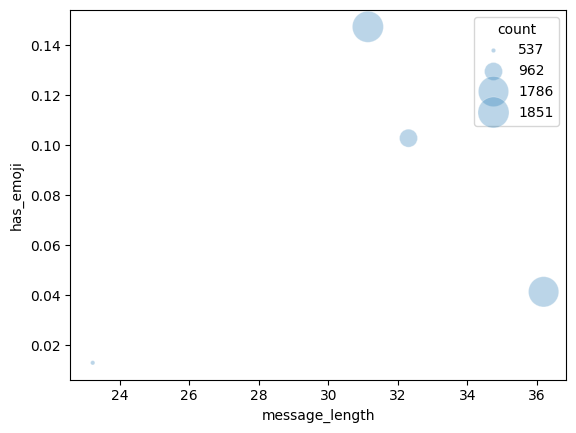

In [353]:
sns.scatterplot(data=p, x="message_length", y="has_emoji", size="count", sizes=(10, 500), alpha=0.3)

In [369]:
df_em =df[df['has_emoji']]
df_nem =df[df['has_emoji']==False]

In [370]:
p_without_emoji=df_nem.groupby(["author"]).agg({
    "message_length": "mean",
    "author": "count",
    "age": "mean",
}).rename(columns={"author": "count"})

In [371]:
p2=df_em.groupby(["author"]).agg({
    "message_length": "mean",
    "author": "count",
    "age": "mean",
    "has_emoji": "count"
}).rename(columns={"author": "count"})

In [372]:
p2

,message_length,count,age,has_emoji
author,,,,
effervescent-camel,44.581081,74,20.351351,74
hilarious-goldfinch,18.707071,99,49.949495,99
nimble-wombat,24.443223,273,50.820513,273
spangled-rabbit,18.714286,7,18.142857,7


<Axes: xlabel='age', ylabel='message_length'>

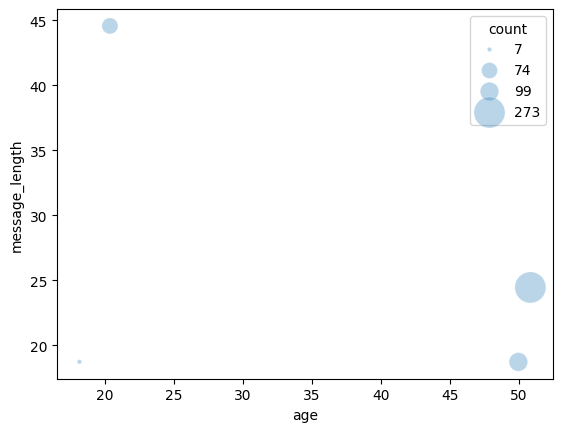

In [376]:
sns.scatterplot(data=p2, x="age", y="message_length", size="count", sizes=(10, 500), alpha=0.3)
#sns.scatterplot(data=p_without_emoji, x="age", y="message_length", size="count", sizes=(10, 500), alpha=0.3)

In [375]:
p_with_emoji =df_em.groupby(["author"]).agg({
    "message_length": "mean",
    "author": "count",
    "age": "mean"
}).rename(columns={"author": "count"})

In [338]:
p_without_emoji

,message_length,count,age,has_emoji
author,,,,
effervescent-camel,35.057377,1708,20.126464,Without Emoji
hilarious-goldfinch,31.042007,857,50.163361,Without Emoji
nimble-wombat,30.605347,1571,51.186505,Without Emoji
spangled-rabbit,22.793951,529,18.410208,Without Emoji


In [339]:
p_with_emoji['diff_length'] = p_with_emoji['message_length']- p_without_emoji['message_length']

In [340]:
p_with_emoji

,message_length,count,age,has_emoji,diff_length
author,,,,,
effervescent-camel,38.444444,72,20.347222,With Emoji,3.387067
hilarious-goldfinch,18.707071,99,49.949495,With Emoji,-12.334936
nimble-wombat,24.443223,273,50.820513,With Emoji,-6.162123
spangled-rabbit,18.714286,7,18.142857,With Emoji,-4.079665


<Axes: xlabel='age', ylabel='count'>

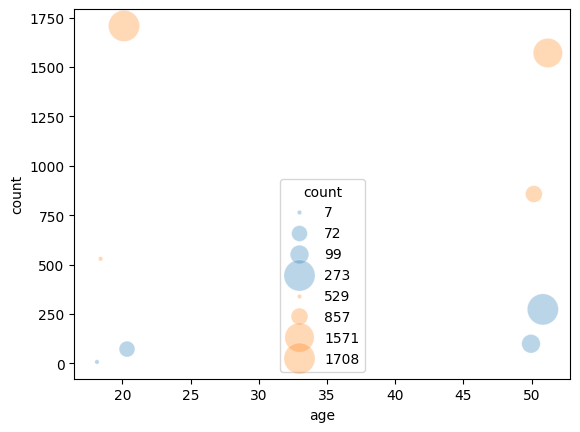

In [337]:
sns.scatterplot(data=p_with_emoji, x="age", y="count", size="count",  sizes=(10, 500), alpha=0.3)
sns.scatterplot(data=p_without_emoji, x="age", y="count", size="count", sizes=(10, 500), alpha=0.3)

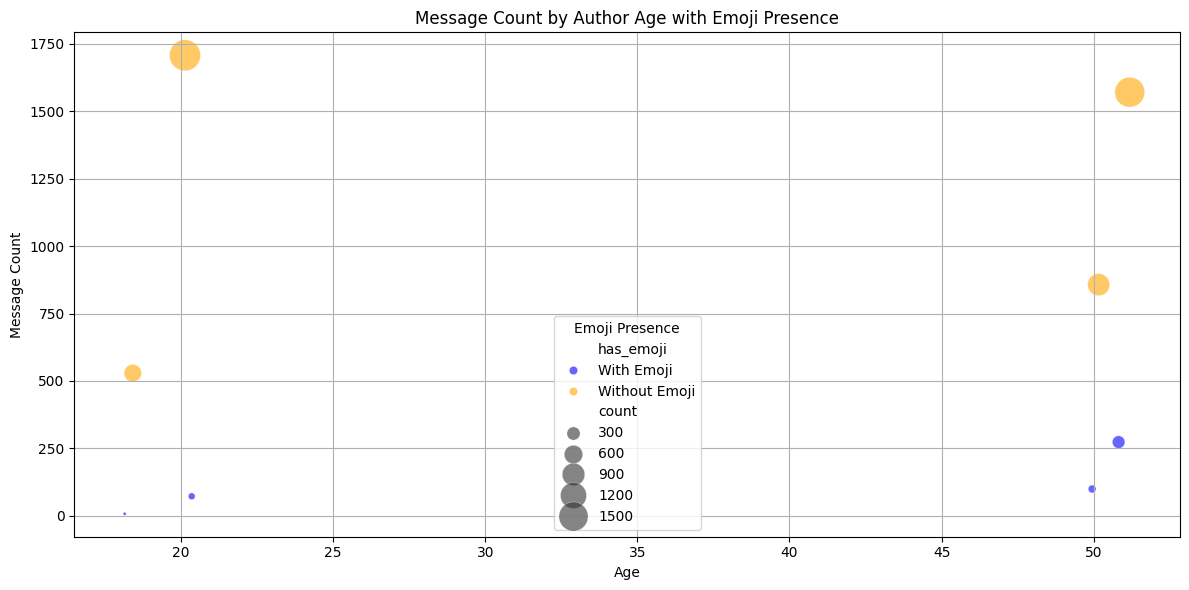

In [333]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming p_with_emoji and p_without_emoji are already created

# Add a column to indicate emoji presence
p_with_emoji['has_emoji'] = 'With Emoji'
p_without_emoji['has_emoji'] = 'Without Emoji'

# Concatenate the two DataFrames
combined_data = pd.concat([p_with_emoji, p_without_emoji])

# Create the scatter plot
plt.figure(figsize=(12, 6))
sns.scatterplot(data=combined_data, x="age", y="count", 
                size="count", sizes=(5, 500), alpha=0.6, 
                hue='has_emoji', palette={'With Emoji': 'blue', 'Without Emoji': 'orange'})

# Add titles and labels
plt.title('Message Count by Author Age with Emoji Presence')
plt.xlabel('Age')
plt.ylabel('Message Count')

# Add a legend and grid
plt.legend(title='Emoji Presence')
plt.grid()

# Show the plot
plt.tight_layout()
plt.show()


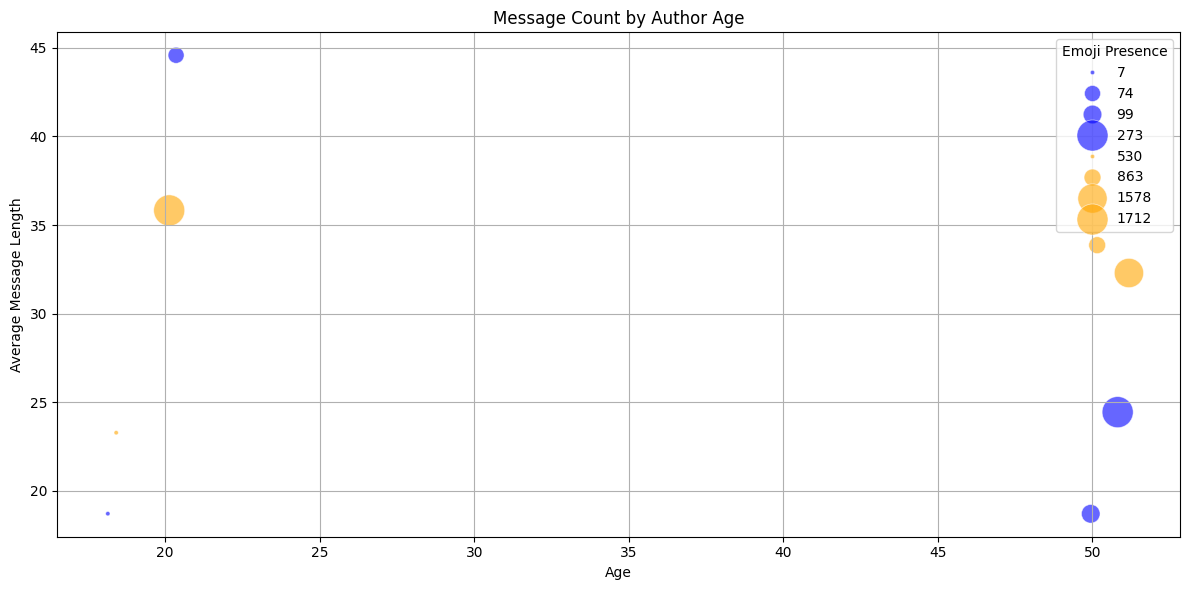

In [388]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate aggregated data for authors with emojis
p_with_emoji = df_em.groupby(["author"]).agg({
    "message_length": "mean",
    "author": "count",
    "age": "mean"
}).rename(columns={"author": "count"})

# Calculate aggregated data for authors without emojis
p_without_emoji = df_nem.groupby(["author"]).agg({
    "message_length": "mean",
    "author": "count",
    "age": "mean"
}).rename(columns={"author": "count"})

# Create the scatter plot
plt.figure(figsize=(12, 6))

# Scatter plot for authors with emojis
sns.scatterplot(data=p_with_emoji, x="age", y="message_length", 
                size="count", sizes=(10, 500), alpha=0.6, 
                color='blue')

# Scatter plot for authors without emojis
sns.scatterplot(data=p_without_emoji, x="age", y="message_length", 
                size="count", sizes=(10, 500), alpha=0.6, 
                color='orange')

# Add titles and labels
plt.title('Message Count by Author Age')
plt.xlabel('Age')
plt.ylabel('Average Message Length')

# Add a legend
plt.legend(title='Emoji Presence')

# Show grid and layout
plt.grid()
plt.tight_layout()
plt.show()


In [259]:
df_em.groupby(["author"]).agg({
    "message_length": "mean",
    "author": "count",
    "age": "mean"
}).rename(columns={"author": "count"})

,message_length,count,age
author,,,
effervescent-camel,44.581081,74,20.351351
hilarious-goldfinch,18.707071,99,49.949495
nimble-wombat,24.443223,273,50.820513
spangled-rabbit,18.714286,7,18.142857


In [258]:
df.groupby(["author"]).agg({
    "message_length": "mean",
    "author": "count",
    "age": "mean"
}).rename(columns={"author": "count"})

,message_length,count,age
author,,,
effervescent-camel,36.190370,1786,20.137738
hilarious-goldfinch,32.304574,962,50.136175
nimble-wombat,31.136683,1851,51.131821
spangled-rabbit,23.223464,537,18.409683


In [253]:
p2 = df.groupby(["author"]).agg({
    "message_length": "mean",
    "author": "count"
}).rename(columns={"author": "count"})

<Axes: xlabel='message_length', ylabel='count'>

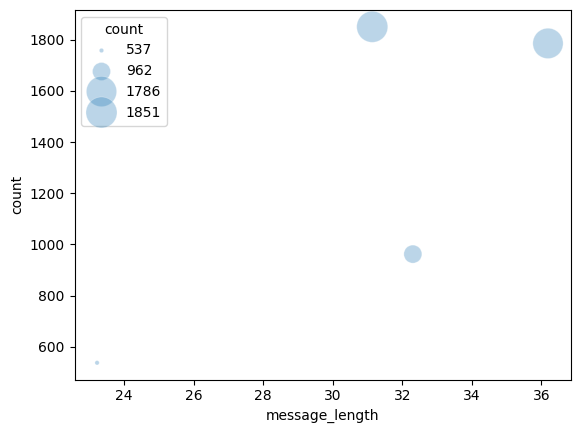

In [255]:
sns.scatterplot(data=p, x="message_length", y="count", size="count", sizes=(10, 500), alpha=0.3)

In [378]:
p["message_length"] /= p["message_length"].max()
p["has_emoji"] /= p["has_emoji"].max()
p["color"] = p.apply(lambda x: "grey" if x["message_length"] > x["has_emoji"] else "red", axis=1)

p

,message_length,has_emoji,count,color
author,,,,
effervescent-camel,1.000000,0.280927,1786,grey
hilarious-goldfinch,0.892629,0.697757,962,grey
nimble-wombat,0.860358,1.000000,1851,red
spangled-rabbit,0.641703,0.088383,537,grey


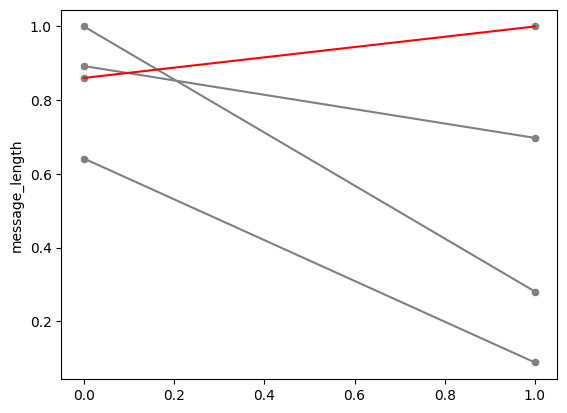

In [379]:
sns.scatterplot(data=p, y="message_length", x=0, color="grey")
sns.scatterplot(data=p, y="has_emoji", x=1, color="grey")
for index, row in p.iterrows():
    sns.lineplot(x=[0, 1], y=[row["message_length"], row["has_emoji"]], color=row["color"])

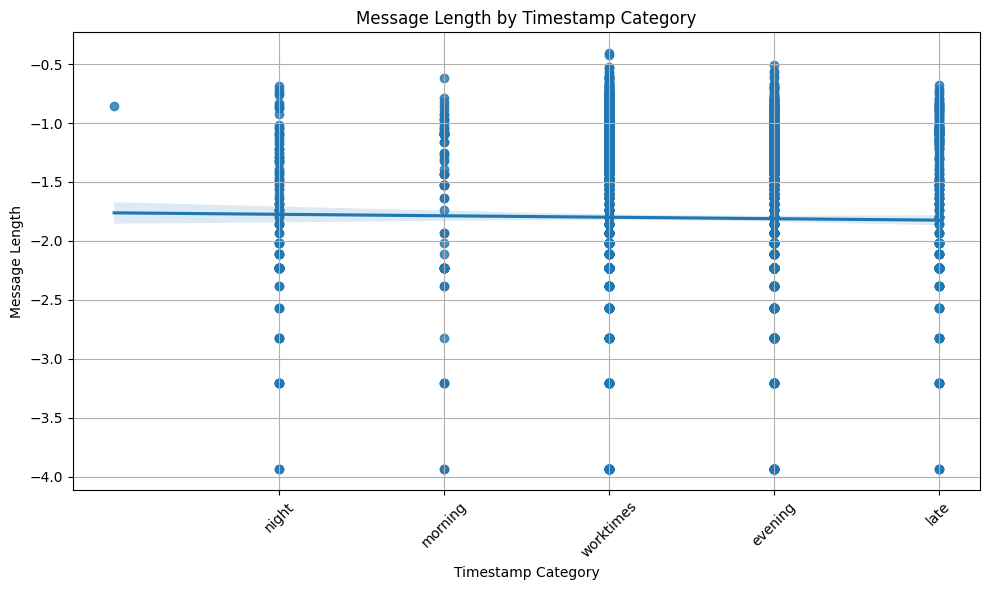

In [161]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Sample data (adjust this to use your actual DataFrame)
data = {
    #'message_length': df["message_length"].apply(lambda x: np.log(x)),
    'message_length': df["message_length"],
    'timestamp_category': df['timestamp_category'],
    'author': df['author']
}

# Create DataFrame
df = pd.DataFrame(data)

# Convert 'timestamp_category' to categorical and then to numeric
df['timestamp_category'] = pd.Categorical(df['timestamp_category'])
df['timestamp_category_code'] = df['timestamp_category'].cat.codes

# Create the regression plot using lmplot
plt.figure(figsize=(10, 6))
sns.regplot(x='timestamp_category_code', y='message_length', data=df,
          )

# Customize x-ticks to show original category names
plt.xticks(ticks=range(len(df['timestamp_category'].cat.categories)),
           labels=df['timestamp_category'].cat.categories, rotation=45)

# Adding titles and labels
plt.title('Message Length by Timestamp Category')
plt.xlabel('Timestamp Category')
plt.ylabel('Message Length')

# Show the plot
plt.grid()
plt.tight_layout()
plt.show()



In [74]:
p.reset_index()
p.columns

Index(['message_length', 'has_emoji', 'count'], dtype='object')

In [45]:
#df_em[df_em['timestamp_category']=='late']

In [111]:
# Calculate the average presence of emojis by time category
average_emoji = df.groupby('hour')['has_emoji'].mean().reset_index()
average_emoji = average_emoji.sort_values(by='has_emoji', ascending=False)
average_emoji

,hour,has_emoji
249,10:36:00,1.0
242,10:28:00,1.0
328,12:05:00,1.0
867,21:21:00,1.0
886,21:41:00,1.0
...,...,...
1006,23:53:00,0.0
1007,23:54:00,0.0
237,10:20:00,0.0
1009,23:57:00,0.0


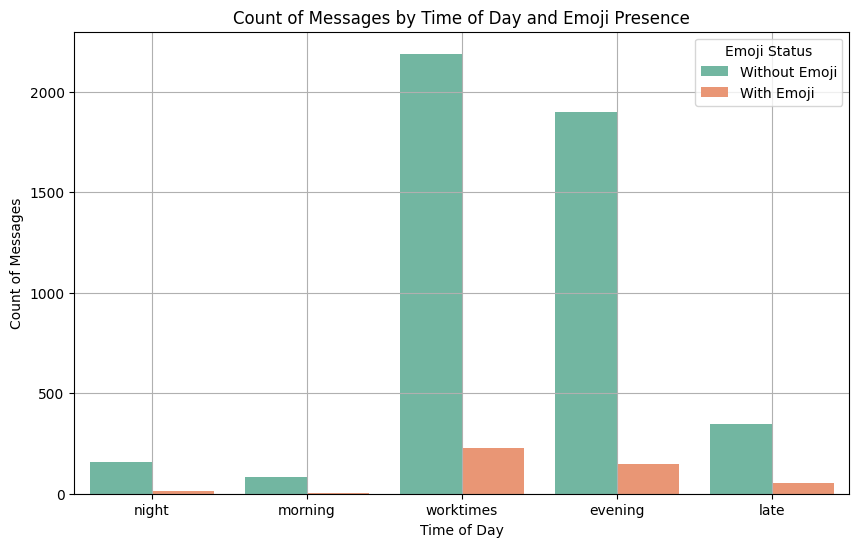

In [186]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt



# Convert emoji presence to categorical
df['emoji_status'] = df['has_emoji'].apply(lambda x: 'With Emoji' if x > 0 else 'Without Emoji')

# Step 1: Create the count plot
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='timestamp_category', hue='emoji_status', palette='Set2')

# Customize the plot
plt.title('Count of Messages by Time of Day and Emoji Presence')
plt.xlabel('Time of Day')
plt.ylabel('Count of Messages')
plt.legend(title='Emoji Status')
plt.grid(True)

# Save the plot with an opaque background
plt.savefig('count_plot_time_of_day_emoji.png', bbox_inches='tight', transparent=False)

# Show the plot
plt.show()


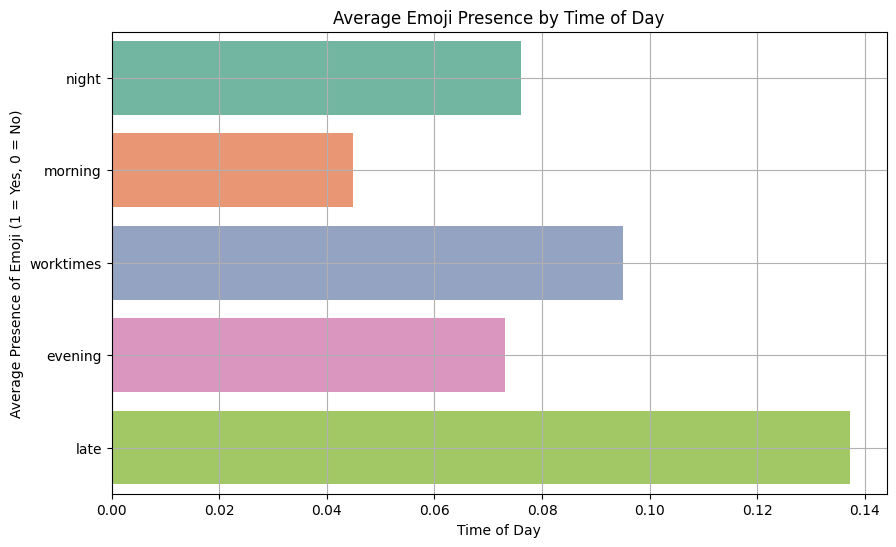

In [128]:
#df[df['has_emoij']]['hour'].value_counts().sort_index(),

df_counts2 = pd.DataFrame(data).reindex(range(24), fill_value=0).fillna(0)

# Step 2: Create the bar plot
plt.figure(figsize=(10, 6))
sns.barplot(data=average_emoji, y='timestamp_category', x='has_emoji', palette='Set2')

# Customize the plot
plt.title('Average Emoji Presence by Time of Day')
plt.xlabel('Time of Day')
plt.ylabel('Average Presence of Emoji (1 = Yes, 0 = No)')
plt.grid(True)

# Save the plot with an opaque background
#plt.savefig('bar_plot_average_emoji_presence.png', bbox_inches='tight', transparent=False)

# Show the plot
plt.show()

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df_counts2 is defined and contains your data
# Step 2: Melt the DataFrame
#df_melted = pd.melt(df_counts2, id_vars=['hour'], var_name='Category', value_name='Count')

# Step 3: Calculate total counts for each hour and normalize as a percentage
#df_melted['Total'] = df_melted.groupby('hour')['Count'].transform('sum')
#df_melted['Percentage'] = df_melted['Count'] / df_melted['Total'] 

# Filter for a specific category, e.g., 'Food'
df_food = df_melted[df_melted['Category'] == 'Plans']

# Step 4: Create a regplot for the 'Food' category
plt.figure(figsize=(12, 6))
sns.regplot(data=df_food, x='hour', y='Percentage', scatter_kws={'color': 'red'}, line_kws={'color': 'black'})
plt.title('Regression of Food Percentage Over Hours')
plt.xlabel('Hour of the Day')
plt.ylabel('Percentage of Total Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

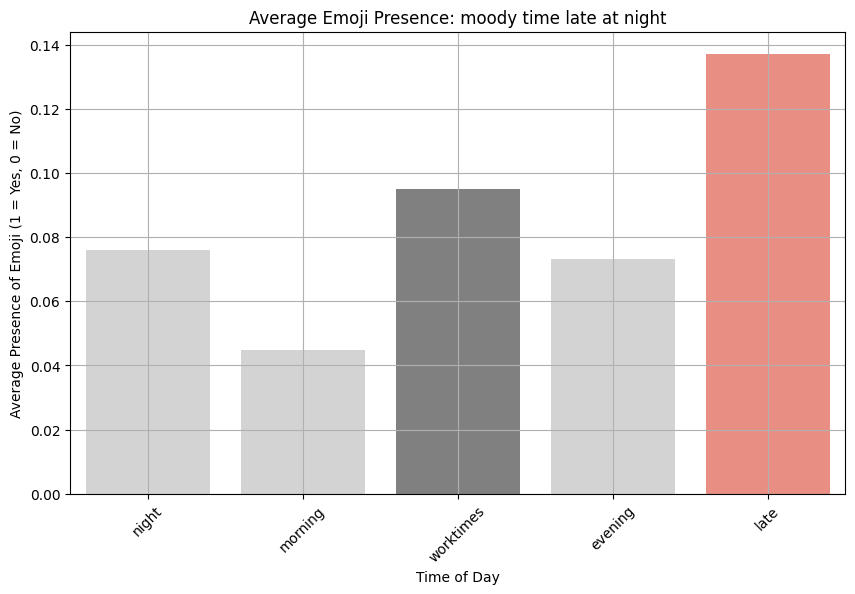

In [166]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Calculate the average presence of emojis by time category
average_emoji = df.groupby('timestamp_category')['has_emoji'].mean().reset_index()

# Sort the DataFrame in descending order based on average emoji presence
average_emoji = average_emoji.sort_values(by='has_emoji', ascending=True)

# Step 2: Create the bar plot
plt.figure(figsize=(10, 6))
colors = ['lightgray', 'lightgray', 'gray', 'lightgray', 'salmon']
sns.barplot(data=average_emoji, x='timestamp_category', y='has_emoji', palette=colors)

# Customize the plot
plt.title('Average Emoji Presence: moody time late at night')
plt.xlabel('Time of Day')
plt.ylabel('Average Presence of Emoji (1 = Yes, 0 = No)')
plt.xticks(rotation=45)  # Rotate x-axis labels if needed
plt.grid(True)

# Save the plot with an opaque background
plt.savefig('bar_plot_average_emoji_presence.png', bbox_inches='tight', transparent=False)

# Show the plot
plt.show()


In [189]:
average_emoji

,author,has_emoji
3,spangled-rabbit,0.013035
0,effervescent-camel,0.041433
1,hilarious-goldfinch,0.102911
2,nimble-wombat,0.147488


C:\Users\Francesca\AppData\Local\Temp\ipykernel_38432\976573939.py:15: UserWarning: The palette list has more values (5) than needed (4), which may not be intended.
  sns.barplot(data=average_emoji, x='author', y='message_length', palette=colors)


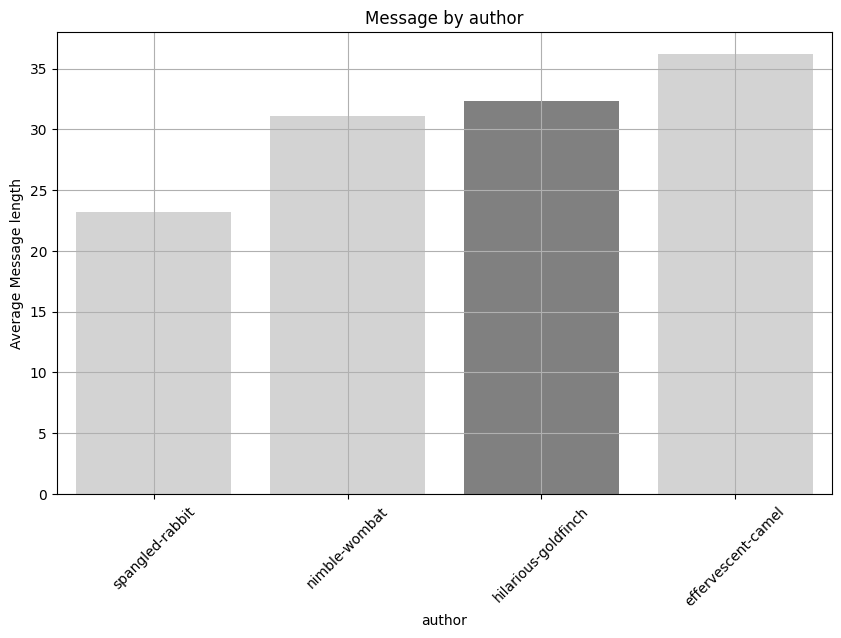

In [193]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Calculate the average presence of emojis by time category
average_emoji = df.groupby('author')['message_length'].mean().reset_index()

# Sort the DataFrame in descending order based on average emoji presence
average_emoji = average_emoji.sort_values(by='message_length', ascending=True)

# Step 2: Create the bar plot
plt.figure(figsize=(10, 6))
colors = ['lightgray', 'lightgray', 'gray', 'lightgray', 'salmon']
sns.barplot(data=average_emoji, x='author', y='message_length', palette=colors)

# Customize the plot
plt.title('Message by author')
plt.xlabel('author')
plt.ylabel('Average Message length')
plt.xticks(rotation=45)  # Rotate x-axis labels if needed
plt.grid(True)

# Save the plot with an opaque background
plt.savefig('bar_plot_average_emoji_presence.png', bbox_inches='tight', transparent=False)

# Show the plot
plt.show()

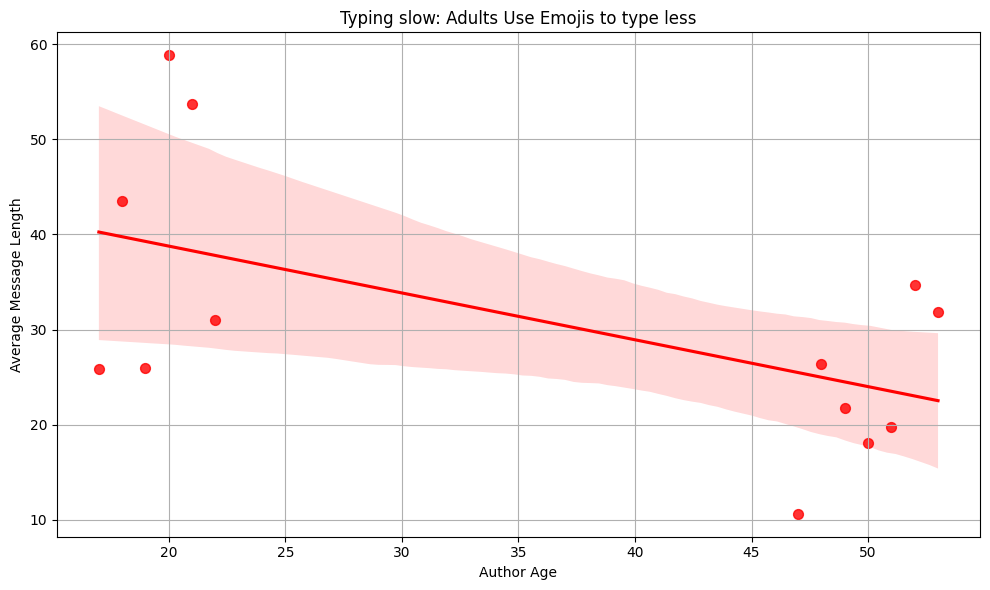

In [434]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df, df_em, and df_nem are already defined

# Calculate the average message length per age
avg_log_length_withemoji = df_em.groupby('age')['message_length'].mean().reset_index()
avg_log_length_without_emoji = df_nem.groupby('age')['message_length'].mean().reset_index()

# Create the regression plot
plt.figure(figsize=(10, 6), facecolor='white')

# Regression line for average length against age
line_with_emoji = sns.regplot(data=avg_log_length_withemoji, x='age', y='message_length', 
                               marker='o', scatter_kws={'s': 50}, color='red', label='With Emojis')
#line_without_emoji = sns.regplot(data=avg_log_length_without_emoji, x='age', y='message_length', 
#                                   marker='o', scatter_kws={'s': 10}, color='gray', label='Without Emojis')

# Add titles and labels
plt.title("Typing slow: Adults Use Emojis to type less")
plt.xlabel('Author Age')
plt.ylabel('Average Message Length')
plt.xticks()
plt.grid()



# Adjust layout
plt.tight_layout()

# Save the plot
plt.savefig('average_message_length_vs_age.png', bbox_inches='tight', transparent=False)

# Show the plot
plt.show()


In [205]:
df_emj= df[df['has_emoji']]
df_emj['age']

6       47
9       48
11      17
12      48
23      47
        ..
5049    51
5093    21
5117    53
5118    53
5124    53
Name: age, Length: 453, dtype: int64

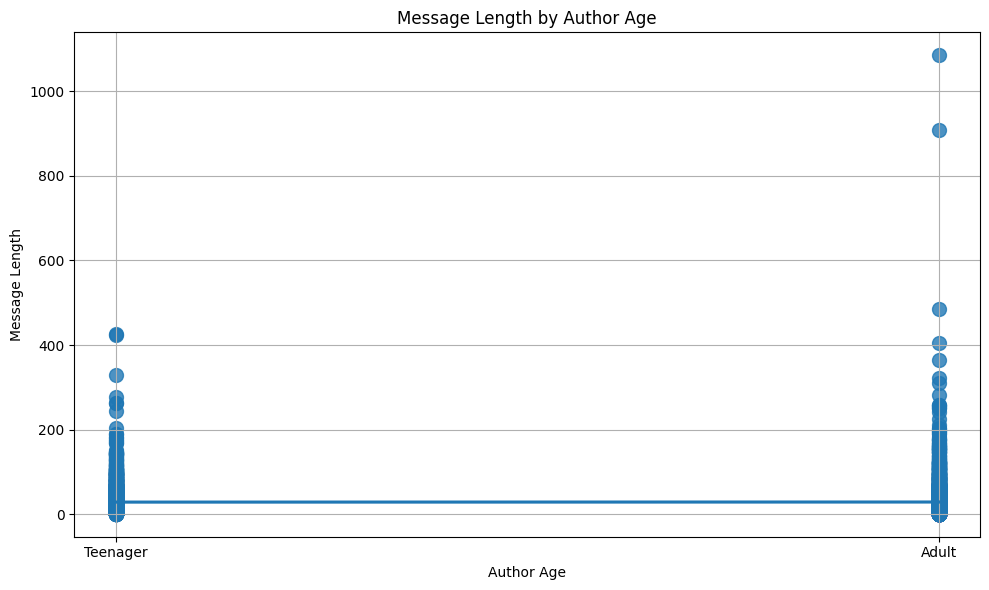

In [85]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Sample DataFrame setup (assuming df is already defined with relevant columns)
# df = pd.DataFrame(...)  # Your DataFrame goes here

# Assign categories to each author
category_mapping = {
    'effervescent-camel': 'teenager',
    'hilarious-goldfinch': 'adult',
    'nimble-wombat': 'adult',
    'spangled-rabbit': 'teenager'
}
df['category'] = df['author'].map(category_mapping)

# Calculate the length of messages
df['message_length'] = df['message'].str.len()  # Adjust this based on how your messages are structured

# Map authors to a numerical age value for plotting
age_mapping = {
    'teenager': 15,  # Example age for teenagers
    'adult': 30      # Example age for adults
}
df['age'] = df['category'].map(age_mapping)

# Create the regression plot
plt.figure(figsize=(10, 6), facecolor='white')

# Regression line for message length against author age
sns.regplot(data=df, x='age', y='message_length', marker='o', scatter_kws={'s': 100})

# Add titles and labels
plt.title("Message Length by Author Age")
plt.xlabel('Author Age')
plt.ylabel('Message Length')
plt.xticks(ticks=[15, 30], labels=['Teenager', 'Adult'])
plt.grid()

# Adjust layout
plt.tight_layout()

# Save the plot
plt.savefig('message_length_vs_age.png', bbox_inches='tight', transparent=False)

# Show the plot
plt.show()


<Figure size 800x600 with 0 Axes>

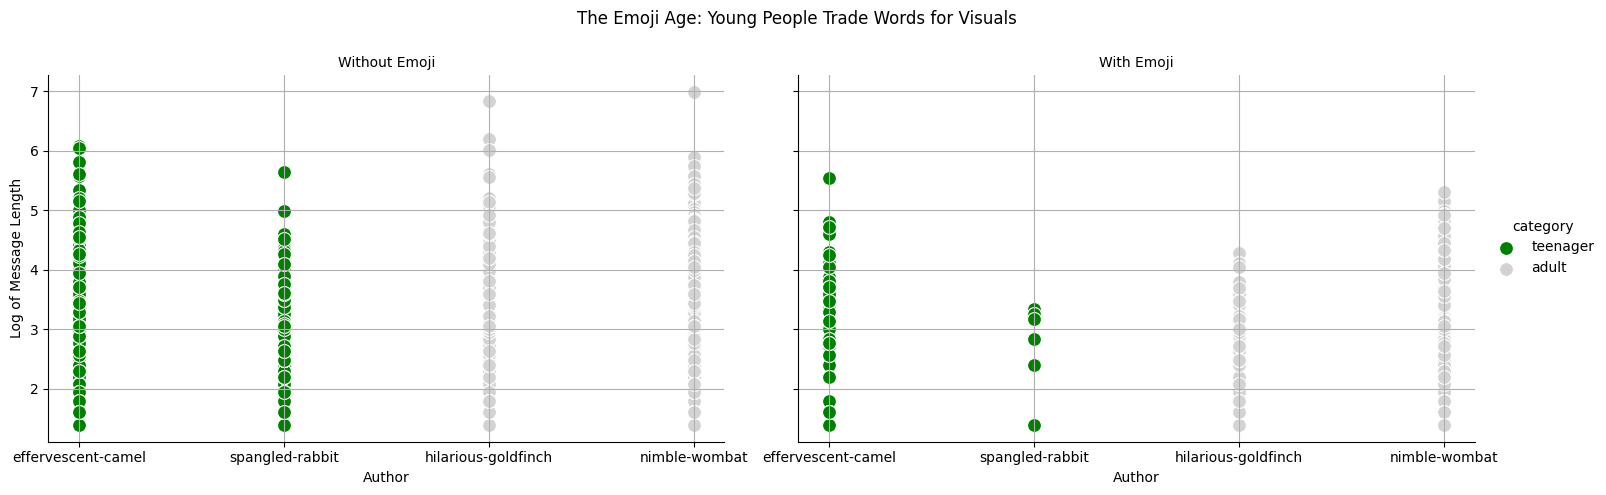

In [12]:
# Assign categories to each author
category_mapping = {
    'effervescent-camel': 'teenager',
    'hilarious-goldfinch': 'adult',
    'nimble-wombat': 'adult',
    'spangled-rabbit': 'teenager'
}
df['category'] = df['author'].map(category_mapping)

# Calculate the logarithm of message length
df['log_len'] = np.log(df['message_length'])

# Create a new column to categorize messages based on emoji presence
df['emoji_status'] = df['has_emoji'].apply(lambda x: 'With Emoji' if x > 0 else 'Without Emoji')

# Sort the DataFrame by author
df_sorted = df.sort_values(by='author')

# Create the scatter plot
plt.figure(figsize=(8, 6), facecolor='white')  
# Create a FacetGrid
g = sns.FacetGrid(df_sorted, col='emoji_status', hue='category', height=5, aspect=1.5, palette={'teenager': 'green', 'adult': 'lightgray'})

# Map the scatter plot to each facet (note that x and y are swapped)
g.map(sns.scatterplot, 'author', 'log_len', s=100)

# Add count annotations
for ax in g.axes.flat:
    # Get the title to determine the emoji status
    emoji_status = ax.get_title().split(' ')[0]  # "With" or "Without"
    
    # Filter the DataFrame based on the emoji status
    for i in range(df_sorted.shape[0]):
        if df_sorted['emoji_status'].iloc[i] == emoji_status:
            ax.text(df_sorted['author'].iloc[i], df_sorted['log_len'].iloc[i], df_sorted['count'].iloc[i], 
                    fontsize=9, ha='right', va='center')

    # Add grid to the axes
    ax.grid(True)

# Add titles and labels
g.set_axis_labels('Author', 'Log of Message Length')
g.set_titles(col_template='{col_name}')

# Add a legend
g.add_legend()

# Adjust layout
plt.subplots_adjust(top=0.85)
g.fig.suptitle("The Emoji Age: Young People Trade Words for Visuals")
plt.grid(True)

# Save the plot
#plt.savefig('4_scatter_plot_with_emojis.png', bbox_inches='tight', transparent=False)  # Save after all plotting commands

# Save the plot with an opaque background
plt.savefig('4_scatter_plot_with_emojis.png', bbox_inches='tight', transparent=False)
# Show the plot
plt.show()

In [87]:
# Assign categories to each author
category_mapping = {
    'effervescent-camel': 'teenager',
    'hilarious-goldfinch': 'adult',
    'nimble-wombat': 'adult',
    'spangled-rabbit': 'teenager'
}
df['category'] = df['author'].map(category_mapping)

# Calculate the logarithm of message length
df['log_len'] = np.log(df['message_length'])

# Create a new column to categorize messages based on emoji presence
df['emoji_status'] = df['has_emoji'].apply(lambda x: 'With Emoji' if x > 0 else 'Without Emoji')

# Sort the DataFrame by author
df_sorted = df.sort_values(by='author')
df_sorted

,timestamp,message,author,has_emoji,is_topk,message_length,has_link,timestamp_category,hour,day_of_week,language,date,isoweek,year-week,log_len,category,emoji_status,age
0,2018-12-11 11:21:00,hoi,effervescent-camel,False,True,3,False,worktimes,11.350000,1,NL,2018-12-11,50,2018-50,1.098612,teenager,Without Emoji,15
3744,2023-08-03 12:00:00,soms halen ze dat in,effervescent-camel,False,True,20,False,worktimes,12.000000,3,IT,2023-08-03,31,2023-31,2.995732,teenager,Without Emoji,15
3745,2023-08-03 12:00:00,app maar gewoon als je vertrekt,effervescent-camel,False,True,31,False,worktimes,12.000000,3,NL,2023-08-03,31,2023-31,3.433987,teenager,Without Emoji,15
3747,2023-08-03 12:01:00,en als je vlucht nummer stuurt kunnen we dat v...,effervescent-camel,False,True,51,False,worktimes,12.016667,3,NL,2023-08-03,31,2023-31,3.931826,teenager,Without Emoji,15
1217,2021-11-10 14:01:00,en eet dan ook niet mee 😂,effervescent-camel,True,True,25,False,worktimes,14.016667,2,NL,2021-11-10,45,2021-45,3.218876,teenager,With Emoji,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3842,2023-08-10 12:10:00,<media weggelaten>,spangled-rabbit,False,True,18,False,worktimes,12.166667,3,Non-verbal,2023-08-10,32,2023-32,2.890372,teenager,Without Emoji,15
3843,2023-08-10 12:13:00,<media weggelaten>,spangled-rabbit,False,True,18,False,worktimes,12.216667,3,Non-verbal,2023-08-10,32,2023-32,2.890372,teenager,Without Emoji,15
1170,2021-10-28 18:53:00,"""stop met zeuren""",spangled-rabbit,False,True,17,False,evening,18.883333,3,NL,2021-10-28,43,2021-43,2.833213,teenager,Without Emoji,15
3826,2023-08-09 12:48:00,en waar,spangled-rabbit,False,True,7,False,worktimes,12.800000,2,NL,2023-08-09,32,2023-32,1.945910,teenager,Without Emoji,15


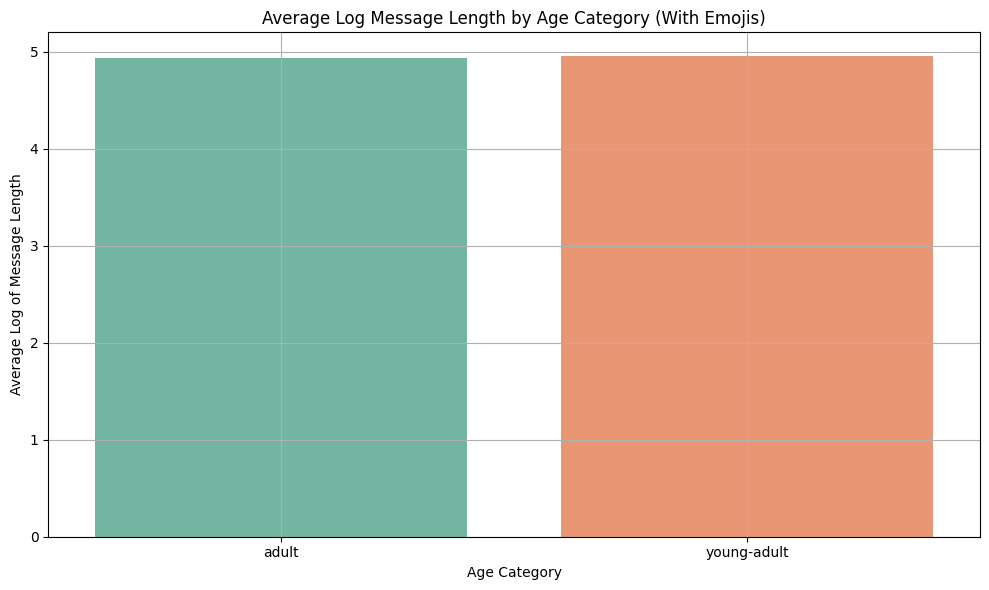

In [16]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Sample DataFrame setup
data = {
    'author': ['effervescent-camel', 'hilarious-goldfinch', 'nimble-wombat', 'spangled-rabbit'],
    'message_length': [100, 150, 200, 130],
    'has_emoji': [1, 0, 1, 0],
    'count': [5, 10, 7, 2]
}

df = pd.DataFrame(data)

# Assign age categories to each author
category_mapping = {
    'effervescent-camel': 'young-adult',
    'hilarious-goldfinch': 'adult',
    'nimble-wombat': 'young-adult',
    'spangled-rabbit': 'adult'
}

# Create a column for age category
df['age_category'] = df['author'].map(category_mapping)

# Calculate the logarithm of message length
df['log_len'] = np.log(df['message_length'])

# Create a new column to categorize messages based on emoji presence
df['emoji_status'] = df['has_emoji'].apply(lambda x: 'With Emoji' if x > 0 else 'Without Emoji')

# Filter the DataFrame for messages with emojis
df_with_emojis = df[df['emoji_status'] == 'With Emoji']

# Step 1: Group by age category and calculate mean log_len
mean_lengths = df.groupby('age_category')['log_len'].mean().reset_index()

# Step 2: Create the bar plot
plt.figure(figsize=(10, 6))
sns.barplot(data=mean_lengths, x='age_category', y='log_len', palette='Set2')
plt.title('Average Log Message Length by Age Category (With Emojis)')
plt.xlabel('Age Category')
plt.ylabel('Average Log of Message Length')
plt.grid(True)
plt.tight_layout()

# Save the plot with an opaque background
plt.savefig('bar_plot_average_log_length.png', bbox_inches='tight', transparent=False)

# Show the plot
plt.show()



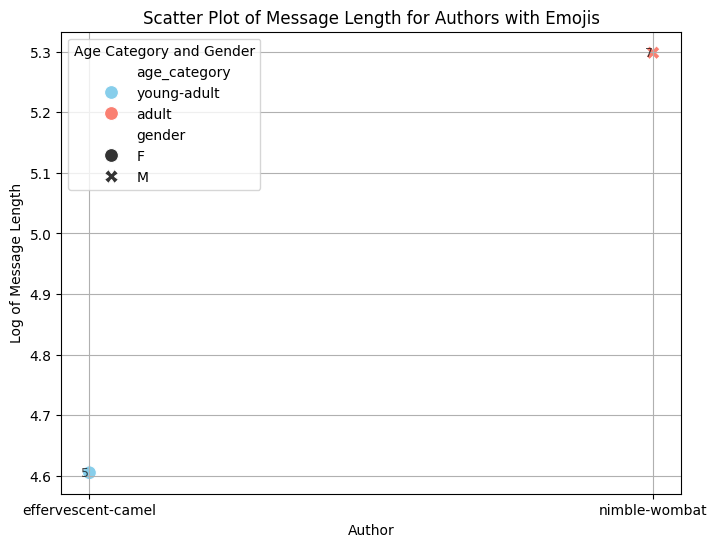

In [79]:
# Create the scatter plot
plt.figure(figsize=(8, 6), facecolor='white')  # Set facecolor to white
sns.scatterplot(data=df_with_emojis, x='author', y='log_len', hue='age_category', style='gender', s=100, 
                palette={'young-adult': 'skyblue', 'adult': 'salmon'})

# Add count annotations
for i in range(df_with_emojis.shape[0]):
    plt.text(df_with_emojis['author'].iloc[i], df_with_emojis['log_len'].iloc[i], 
             df_with_emojis['count'].iloc[i], fontsize=9, ha='right', va='center', alpha=0.7)

# Add titles and labels
plt.title('Scatter Plot of Message Length for Authors with Emojis')
plt.xlabel('Author')
plt.ylabel('Log of Message Length')
plt.grid(True)
plt.legend(title='Age Category and Gender')

# Save the plot
#plt.savefig('scatter_plot_with_emojis.png', bbox_inches='tight', transparent=False)  # Ensure background is not transparent

# Show the plot
plt.show()

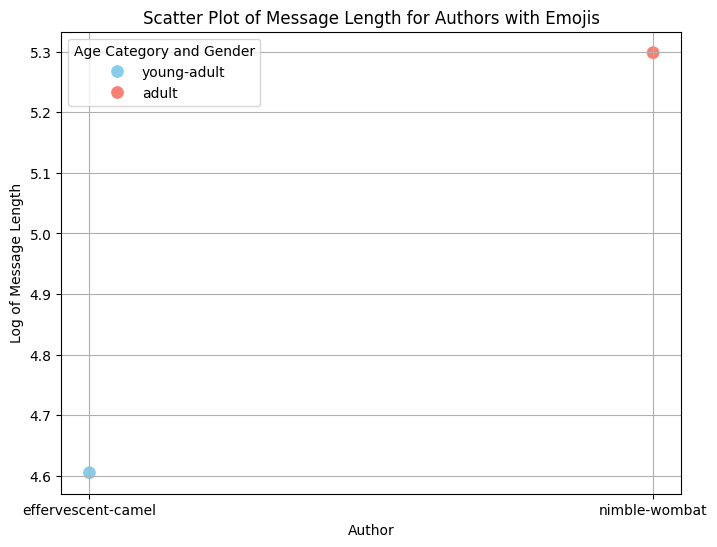

In [18]:
# Assign genders and age categories to each author
category_mapping = {
    'effervescent-camel': ('F', 'young-adult'),
    'hilarious-goldfinch': ('F', 'adult'),
    'nimble-wombat': ('M', 'adult'),
    'spangled-rabbit': ('M', 'young-adult')
}

# Create separate columns for gender and age category
df['gender'], df['age_category'] = zip(*df['author'].map(category_mapping))

# Calculate the logarithm of message length
df['log_len'] = np.log(df['message_length'])

# Create a new column to categorize messages based on emoji presence
df['emoji_status'] = df['has_emoji'].apply(lambda x: 'With Emoji' if x > 0 else 'Without Emoji')

# Filter the DataFrame for messages with emojis
df_with_emojis = df[df['emoji_status'] == 'With Emoji']

# Create the scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_with_emojis, x='author', y='log_len', hue='age_category',  s=100, palette={'young-adult': 'skyblue', 'adult': 'salmon'})



# Add titles and labels
plt.title('Scatter Plot of Message Length for Authors with Emojis')
plt.xlabel('Author')
plt.ylabel('Log of Message Length')
plt.grid(True)
plt.legend(title='Age Category and Gender')
plt.show()

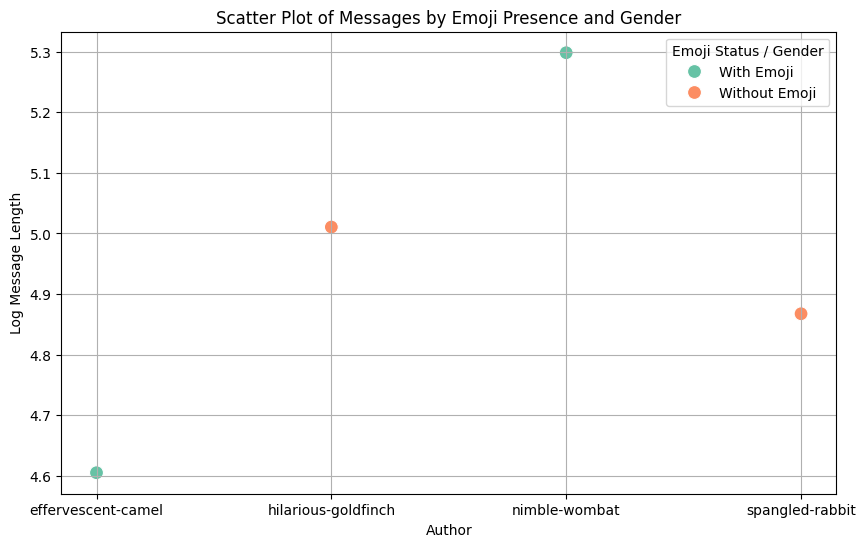

In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt




# Assign genders to each author
gender_mapping = {
    'effervescent-camel': 'F',
    'hilarious-goldfinch': 'F',
    'nimble-wombat': 'M',
    'spangled-rabbit': 'M'
}

df['gender'] = df['author'].map(gender_mapping)

# Create a new column to categorize messages based on emoji presence
df['emoji_status'] = df['has_emoji'].apply(lambda x: 'With Emoji' if x > 0 else 'Without Emoji')

# Create the scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='author', y='log_len', hue='emoji_status', palette='Set2', s=100)

plt.title('Scatter Plot of Messages by Emoji Presence and Gender')
plt.xlabel('Author')
plt.ylabel('Log Message Length')
plt.legend(title='Emoji Status / Gender')
plt.grid(True)
plt.show()


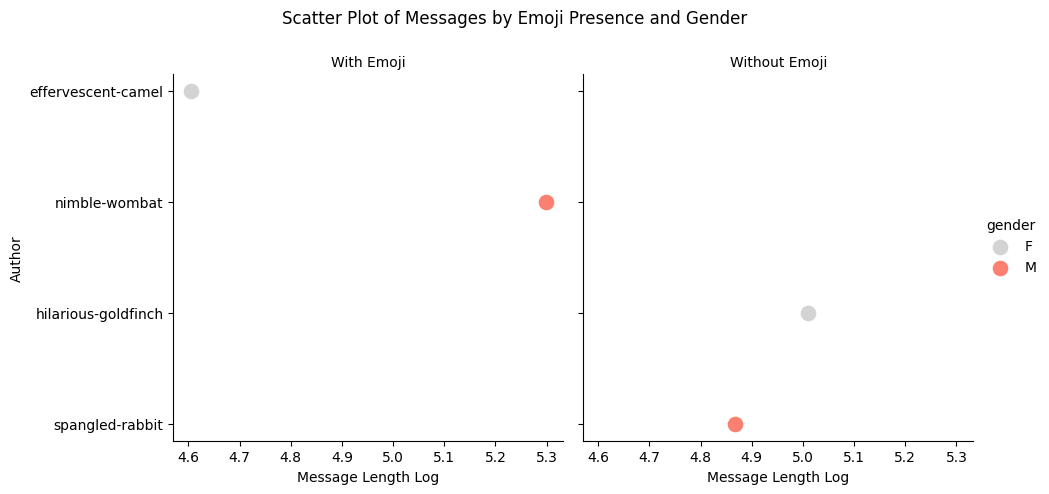

In [20]:
df['gender'] = df['author'].map(gender_mapping)

# Create a new column to categorize messages based on emoji presence
df['emoji_status'] = df['has_emoji'].apply(lambda x: 'With Emoji' if x > 0 else 'Without Emoji')

# Create a color palette
custom_palette = {'F': 'lightgray', 'M': 'salmon'}

# Create the FacetGrid
g = sns.FacetGrid(df, col='emoji_status', hue='gender', height=5, aspect=1, palette=custom_palette)


# Map the scatter plot to each facet
g.map(sns.scatterplot, 'log_len', 'author', s=150)
g.add_legend()

# Add titles and labels
g.set_axis_labels('Message Length Log', 'Author')
g.set_titles(col_template='{col_name}')

plt.subplots_adjust(top=0.85)
g.fig.suptitle('Scatter Plot of Messages by Emoji Presence and Gender')
plt.show()

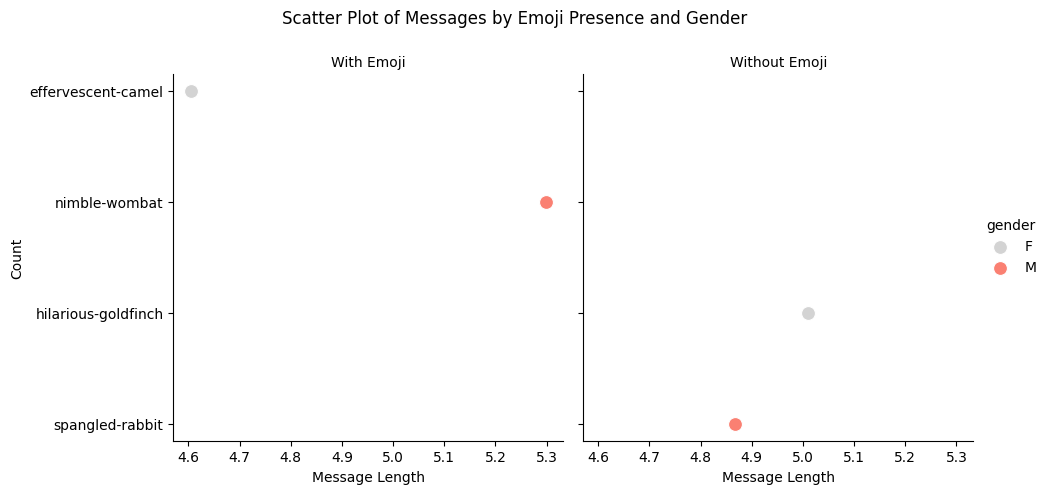

In [21]:
df['gender'] = df['author'].map(gender_mapping)

# Create a new column to categorize messages based on emoji presence
df['emoji_status'] = df['has_emoji'].apply(lambda x: 'With Emoji' if x > 0 else 'Without Emoji')

# Create a custom color palette for genders
gender_palette = {'F': 'skyblue', 'M': 'salmon'}


# Create the FacetGrid
g = sns.FacetGrid(df, col='emoji_status', hue='gender', height=5, aspect=1, palette=custom_palette)

# Map the scatter plot to each facet
g.map(sns.scatterplot, 'log_len', 'author', s=100)

# Add a legend
g.add_legend()

# Set titles and labels
g.set_axis_labels('Message Length', 'Count')
g.set_titles(col_template='{col_name}')




plt.subplots_adjust(top=0.85)
g.fig.suptitle('Scatter Plot of Messages by Emoji Presence and Gender')
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

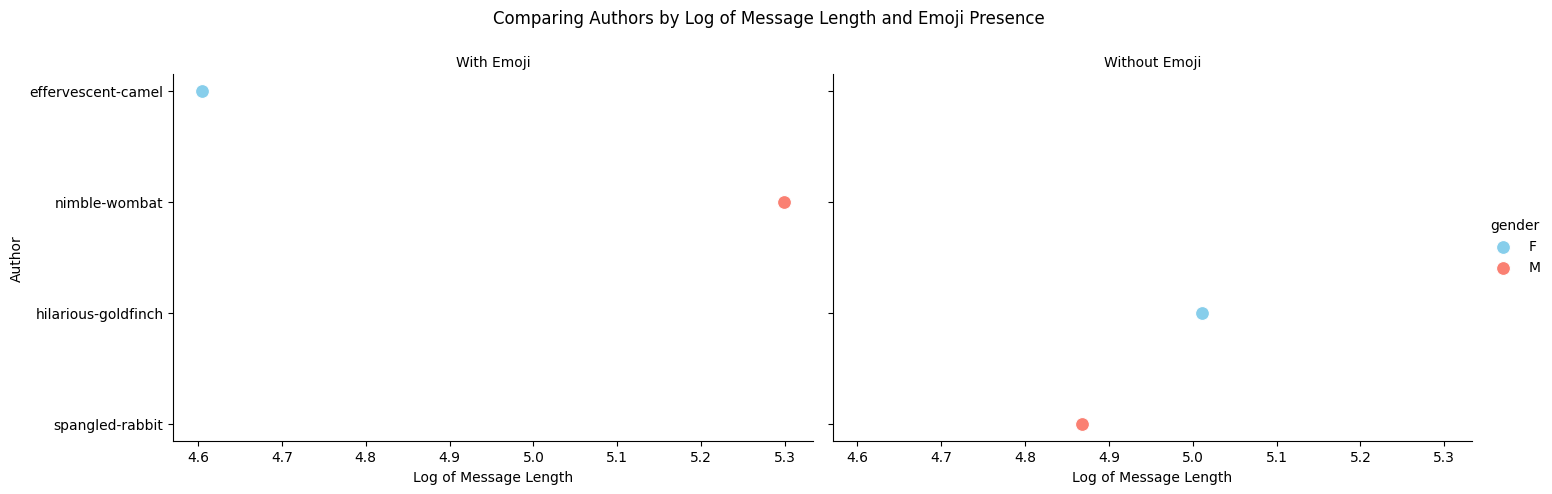

In [22]:
# Create a new column to categorize messages based on emoji presence
df['emoji_status'] = df['has_emoji'].apply(lambda x: 'With Emoji' if x > 0 else 'Without Emoji')

# Create a FacetGrid
g = sns.FacetGrid(df, col='emoji_status', hue='gender', height=5, aspect=1.5, palette={'F': 'skyblue', 'M': 'salmon'})

# Map the scatter plot to each facet
g.map(sns.scatterplot, 'log_len', 'author', s=100)

# Add titles and labels
g.set_axis_labels('Log of Message Length', 'Author')
g.set_titles(col_template='{col_name}')

# Add a legend
g.add_legend()

# Adjust layout
plt.subplots_adjust(top=0.85)
g.fig.suptitle('Comparing Authors by Log of Message Length and Emoji Presence')
plt.show

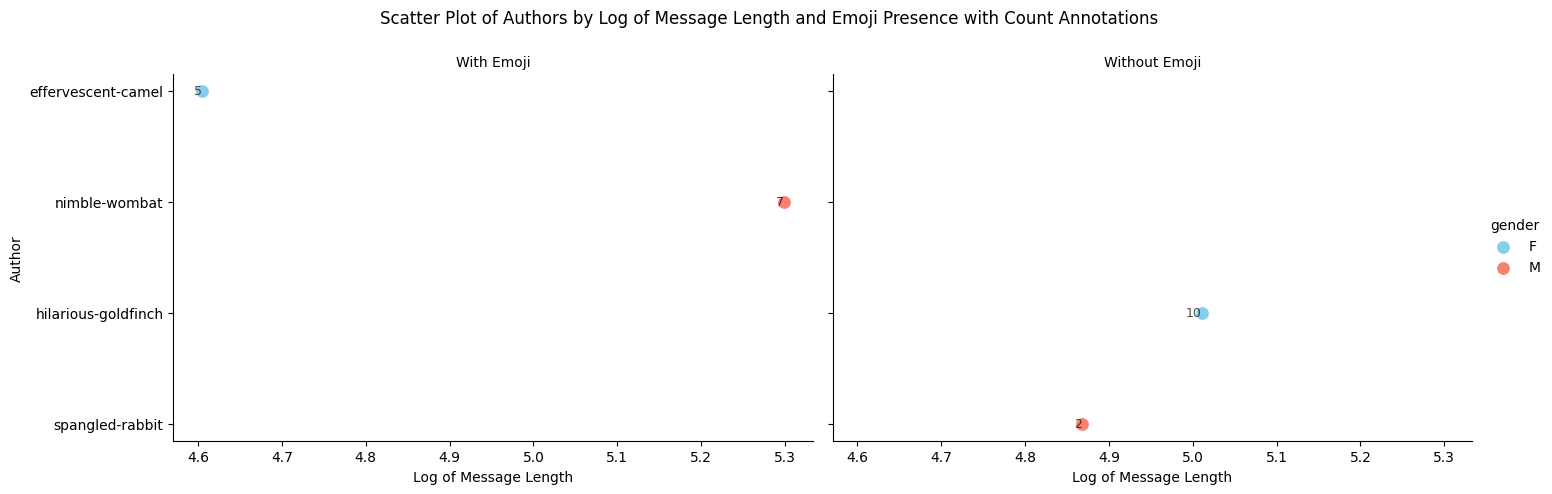

In [23]:
# Create a FacetGrid
g = sns.FacetGrid(df, col='emoji_status', hue='gender', height=5, aspect=1.5, palette={'F': 'skyblue', 'M': 'salmon'})

# Map the scatter plot to each facet
g.map(sns.scatterplot, 'log_len', 'author', s=100)



# Add count annotations
for ax in g.axes.flat:
    for i in range(df.shape[0]):
        # Get the correct axis based on emoji status
        if df['emoji_status'][i] in ax.get_title():
            ax.text(df['log_len'][i], df['author'][i], df['count'][i], 
                    fontsize=9, ha='right', va='center', alpha=0.7)

# Add titles and labels
g.set_axis_labels('Log of Message Length', 'Author')
g.set_titles(col_template='{col_name}')

# Add a legend
g.add_legend()

# Adjust layout
plt.subplots_adjust(top=0.85)
g.fig.suptitle('Scatter Plot of Authors by Log of Message Length and Emoji Presence with Count Annotations')
plt.show()

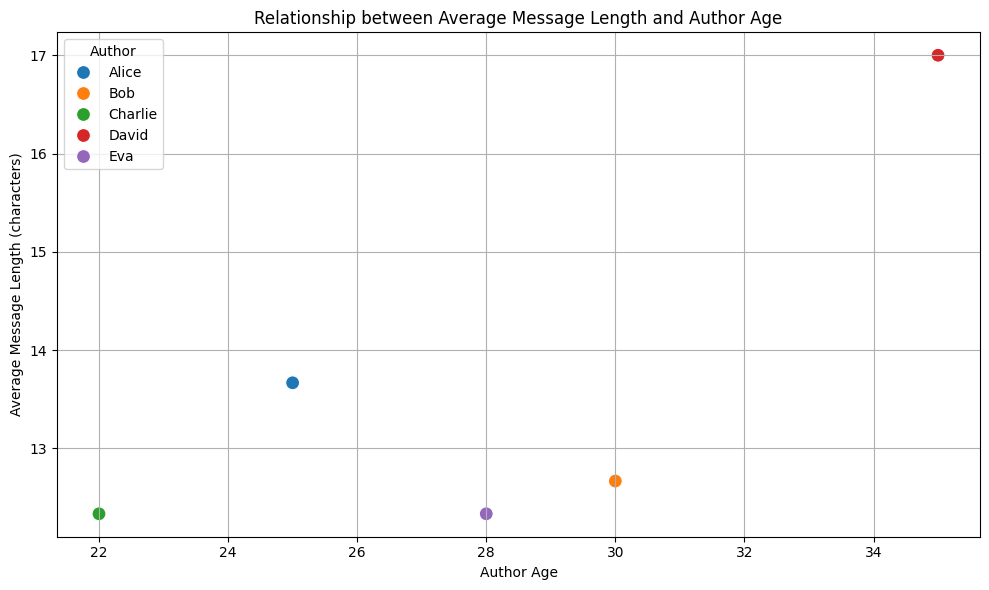

In [31]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Sample data: a list of authors with their ages and messages
data2 = {
    'author': ['Alice', 'Bob', 'Charlie', 'David', 'Eva'],
    'age': [25, 30, 22, 35, 28],
    'messages': [
        ["Hello!", "How are you doing?", "Nice to meet you!"],
        ["Hey there!", "What's up?", "Let's grab coffee!"],
        ["Hi!", "Just checking in.", "Have a great day!"],
        ["Greetings!", "Looking forward to the meeting.", "Take care!"],
        ["Hello!", "What do you think?", "See you soon!"]
    ]
}

# Step 1: Create a DataFrame
df2 = pd.DataFrame(data2)

# Step 2: Calculate average message length for each author
df2['avg_length'] = df2['messages'].apply(lambda messages: sum(len(msg) for msg in messages) / len(messages))

# Step 3: Plot the relationship
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df2, x='age', y='avg_length', hue='author', s=100)
plt.title('Relationship between Average Message Length and Author Age')
plt.xlabel('Author Age')
plt.ylabel('Average Message Length (characters)')
plt.legend(title='Author')
plt.grid(True)
plt.tight_layout()
plt.show()


Lowess stands for Locally Weighted Scatterplot Smoothing, and it is a non-parametric regression method that fits a smooth curve to the data. It is a useful tool to explore the relationship between two variables, but it is not a model in the traditional sense. It is a tool to help us understand the data, not to make predictions.

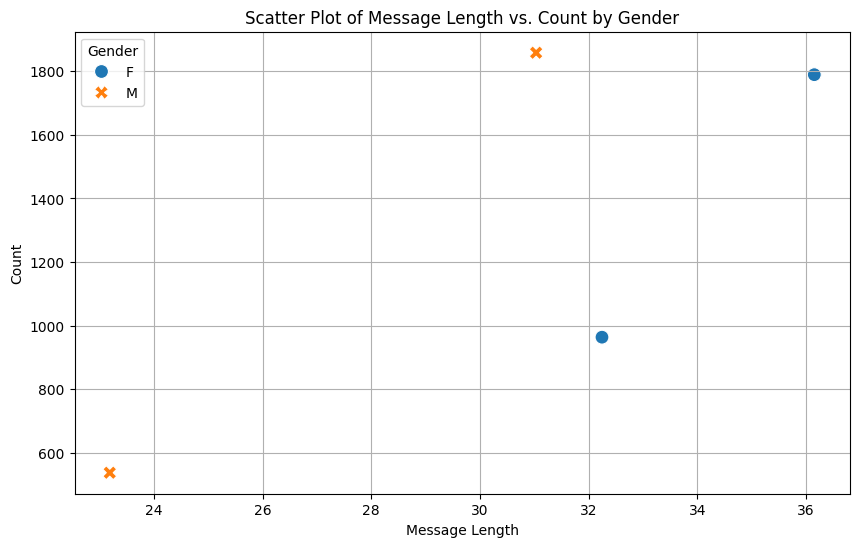

In [21]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Sample data
data = {
    'author': ['effervescent-camel', 'hilarious-goldfinch', 'nimble-wombat', 'spangled-rabbit'],
    'message_length': [36.152040, 32.245851, 31.034446, 23.189591],
    'has_emoji': [0.038010, 0.085062, 0.141550, 0.011152],
    'count': [1789, 964, 1858, 538]
}

# Create DataFrame
df = pd.DataFrame(data)

# Assign genders to each author
gender_mapping = {
    'effervescent-camel': 'F',
    'hilarious-goldfinch': 'F',
    'nimble-wombat': 'M',
    'spangled-rabbit': 'M'
}

df['gender'] = df['author'].map(gender_mapping)

# Create the scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='message_length', y='count', hue='gender', style='gender', s=100)

plt.title('Scatter Plot of Message Length vs. Count by Gender')
plt.xlabel('Message Length')
plt.ylabel('Count')
plt.legend(title='Gender')
plt.grid(True)
plt.show()


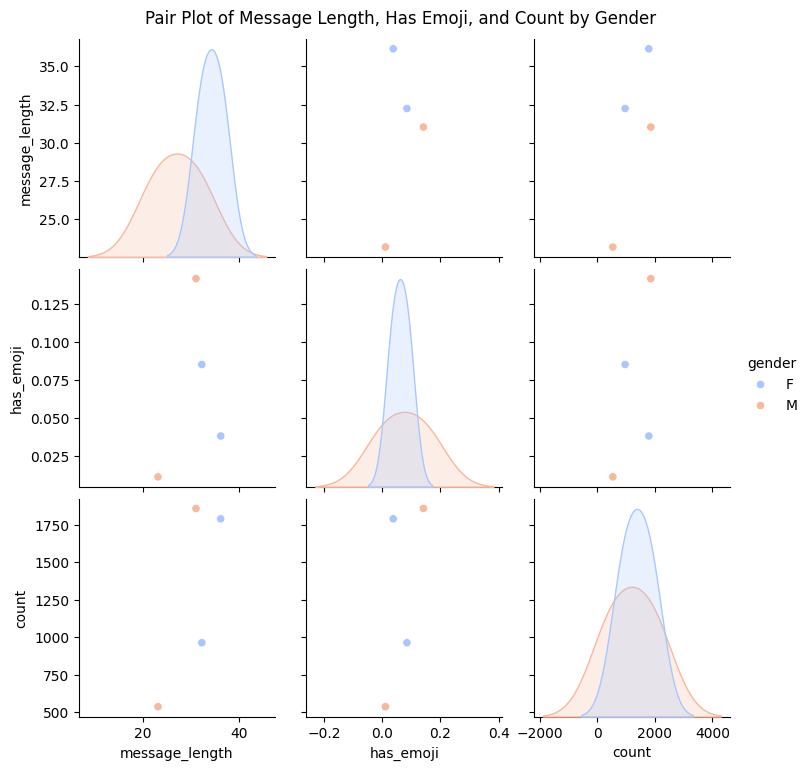

In [22]:
# Select only relevant columns for pair plot
sns.pairplot(df, hue='gender', vars=['message_length', 'has_emoji', 'count'], palette='coolwarm')
plt.suptitle('Pair Plot of Message Length, Has Emoji, and Count by Gender', y=1.02)
plt.show()

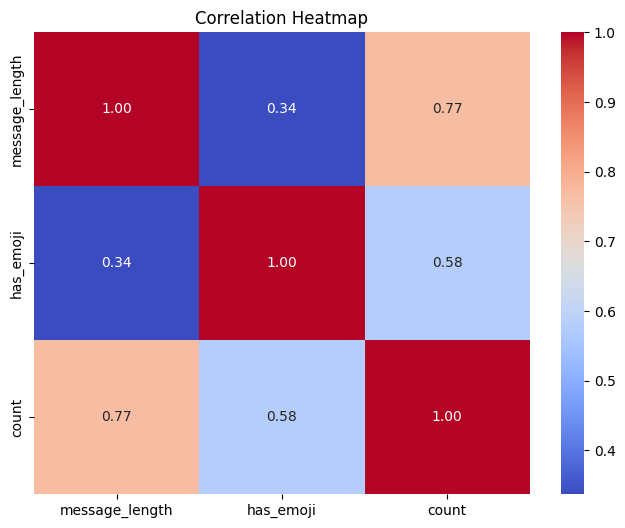

In [24]:
# Calculate the correlation matrix using only numeric columns
correlation_matrix = df[['message_length', 'has_emoji', 'count']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()



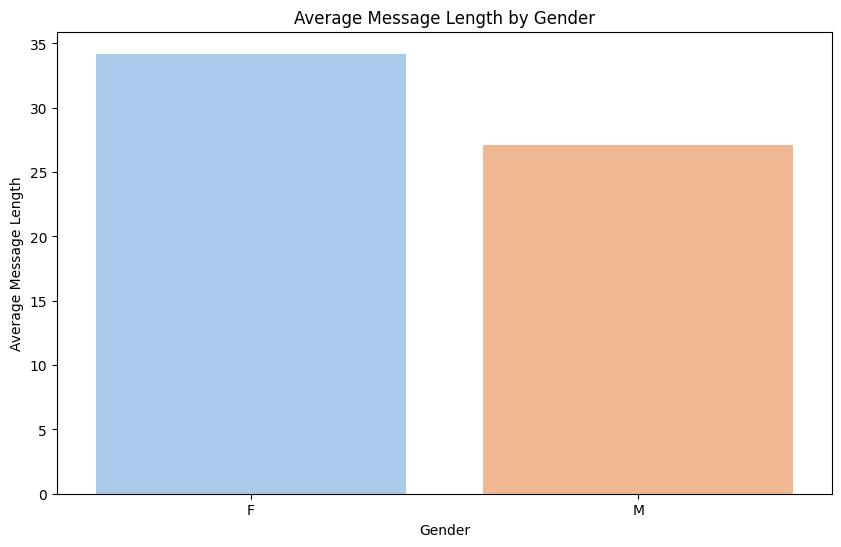

In [25]:
# Calculate average message length and count by gender
avg_df = df.groupby('gender').agg({'message_length': 'mean', 'count': 'mean'}).reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(data=avg_df, x='gender', y='message_length', palette='pastel')
plt.title('Average Message Length by Gender')
plt.xlabel('Gender')
plt.ylabel('Average Message Length')
plt.show()


In [1]:
profiel = {'Achternaam': 'Krstic', 'Naam': 'Milan Krstic', 'Leeftijd': 22, 'Geslacht': 'man', 'Geboortedatum': '12/03/2000', 'Address': 'Bogdanovića 34, Novi Knezevac', 'Hobbies': 'Wandelen in de bergen, hondentraining', 'Werk': 'Student, Universiteit van Novi Knezevac, 2 jaar', 'Talen': 'Servisch, Engels', 'Fun-fact': 'Hij is een fervent bergbeklimmer en houdt van het trainen van zijn hond.', 'Email': 'milan.krstic@proton.me', 'Extra': 'Hij heeft een hond genaamd Max en houdt van het eten van traditionele Servische gerechten.', 'Story': 'Milan Krstic is een 22-jarige man, geboren op 12 maart 2000. Hij studeert aan de Universiteit van Novi Knezevac en is een fervent bergbeklimmer. Hij houdt van het trainen van zijn hond Max en geniet van traditionele Servische gerechten. Hij spreekt Servisch en Engels.', 'Description': 'Milan Krstic is een 22-jarige man, geboren op 12 maart 2000. Hij studeert aan de Universiteit van Novi Knezevac en is een fervent bergbeklimmer. Hij houdt van het trainen van zijn hond Max en geniet van traditionele Servische gerechten. Hij spreekt Servisch en Engels. Hij woont in Novi Knezevac, Servië. Hij is een student en studeert al 2 jaar aan de Universiteit van Novi Knezevac. Hij houdt van wandelen in de bergen en hondentraining. Hij is een fervent bergbeklimmer en houdt van het trainen van zijn hond. Hij heeft een hond genaamd Max en houdt van het eten van traditionele Servische gerechten. Zijn email is milan.krstic@proton.me.'}

In [23]:
import pandas as pd
df = pd.DataFrame(profiel, index=[0]).T

In [25]:
df.columns= ["Persoon info"]

In [37]:
html_table = df.to_html(index=True, border=3, header=True, col_space= 200, notebook=True, justify='left')

In [38]:
html_table

'<div>\n<style scoped>\n    .dataframe tbody tr th:only-of-type {\n        vertical-align: middle;\n    }\n\n    .dataframe tbody tr th {\n        vertical-align: top;\n    }\n\n    .dataframe thead th {\n        text-align: right;\n    }\n</style>\n<table border="3" class="dataframe">\n  <thead>\n    <tr style="text-align: left;">\n      <th style="min-width: 200px;"></th>\n      <th style="min-width: 200px;">Persoon info</th>\n    </tr>\n  </thead>\n  <tbody>\n    <tr>\n      <th>Achternaam</th>\n      <td>Krstic</td>\n    </tr>\n    <tr>\n      <th>Naam</th>\n      <td>Milan Krstic</td>\n    </tr>\n    <tr>\n      <th>Leeftijd</th>\n      <td>22</td>\n    </tr>\n    <tr>\n      <th>Geslacht</th>\n      <td>man</td>\n    </tr>\n    <tr>\n      <th>Geboortedatum</th>\n      <td>12/03/2000</td>\n    </tr>\n    <tr>\n      <th>Address</th>\n      <td>Bogdanovića 34, Novi Knezevac</td>\n    </tr>\n    <tr>\n      <th>Hobbies</th>\n      <td>Wandelen in de bergen, hondentraining</td>\n   

<html><div>\n<style scoped>\n    .dataframe tbody tr th:only-of-type {\n        vertical-align: middle;\n    }\n\n    .dataframe tbody tr th {\n        vertical-align: top;\n    }\n\n    .dataframe thead th {\n        text-align: right;\n    }\n</style>\n<table border="3" class="dataframe">\n  <thead>\n    <tr style="text-align: right;">\n      <th style="min-width: 200px;"></th>\n      <th style="min-width: 200px;">Persoon info</th>\n    </tr>\n  </thead>\n  <tbody>\n    <tr>\n      <th>Achternaam</th>\n      <td>Krstic</td>\n    </tr>\n    <tr>\n      <th>Naam</th>\n      <td>Milan Krstic</td>\n    </tr>\n    <tr>\n      <th>Leeftijd</th>\n      <td>22</td>\n    </tr>\n    <tr>\n      <th>Geslacht</th>\n      <td>man</td>\n    </tr>\n    <tr>\n      <th>Geboortedatum</th>\n      <td>12/03/2000</td>\n    </tr>\n    <tr>\n      <th>Address</th>\n      <td>Bogdanovića 34, Novi Knezevac</td>\n    </tr>\n    <tr>\n      <th>Hobbies</th>\n      <td>Wandelen in de bergen, hondentraining</td>\n    </tr>\n    <tr>\n      <th>Werk</th>\n      <td>Student, Universiteit van Novi Knezevac, 2 jaar</td>\n    </tr>\n    <tr>\n      <th>Talen</th>\n      <td>Servisch, Engels</td>\n    </tr>\n    <tr>\n      <th>Fun-fact</th>\n      <td>Hij is een fervent bergbeklimmer en houdt van ...</td>\n    </tr>\n    <tr>\n      <th>Email</th>\n      <td>milan.krstic@proton.me</td>\n    </tr>\n    <tr>\n      <th>Extra</th>\n      <td>Hij heeft een hond genaamd Max en houdt van he...</td>\n    </tr>\n    <tr>\n      <th>Story</th>\n      <td>Milan Krstic is een 22-jarige man, geboren op ...</td>\n    </tr>\n    <tr>\n      <th>Description</th>\n      <td>Milan Krstic is een 22-jarige man, geboren op ...</td>\n    </tr>\n  </tbody>\n</table>\n</div></html>

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from loguru import logger
import numpy as np
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


In [2]:
#!pip install tomllib

In [238]:
import tomllib
configfile = Path("../config.toml").resolve()
with configfile.open("rb") as f:
    config = tomllib.load(f)
config

{'raw': 'data/raw',
 'processed': 'data/processed',
 'input': 'WhatsApp_chat.txt',
 'current': 'whatsapp-20240916-104455.parq'}

In [438]:
def convert_to_decimal_hours(timestamp):
    dec_hour = timestamp.hour + timestamp.minute / 60 + timestamp.second / 3600
    return dec_hour




In [439]:
datafile = "../data/processed/whatsapp-20240916-104455.parq"
df = pd.read_parquet(datafile)
#df.head()

In [440]:
df["hour"] = df["timestamp"].apply(convert_to_decimal_hours)
df["log_len"] = df["message_length"].apply(lambda x: np.log(x))
dob_mapping = {'effervescent-camel': 2002, 'nimble-wombat':1971, 'hilarious-goldfinch':1972,
       'spangled-rabbit':2004}
df['dob'] = df['author'].map(dob_mapping)


In [441]:
#include age in the features (cleanup stage)
df['year'] = df["timestamp"].apply(lambda x: x.year)
df['age'] = df['year']-df['dob']
df.drop(['dob'], inplace=True, axis=1)

In [444]:
def convert_to_decimal_hours(timestamp):
    dec_hour = timestamp.hour + timestamp.minute / 60 + timestamp.second / 3600
    return dec_hour

df["hour"] = df["timestamp"].apply(convert_to_decimal_hours)
df["log_len"] = df["message_length"].apply(lambda x: np.log(x))
#df.head()


In [445]:
df_with_emoji =df[df['has_emoji']]
df_withou_emoji =df[df['has_emoji']==False]

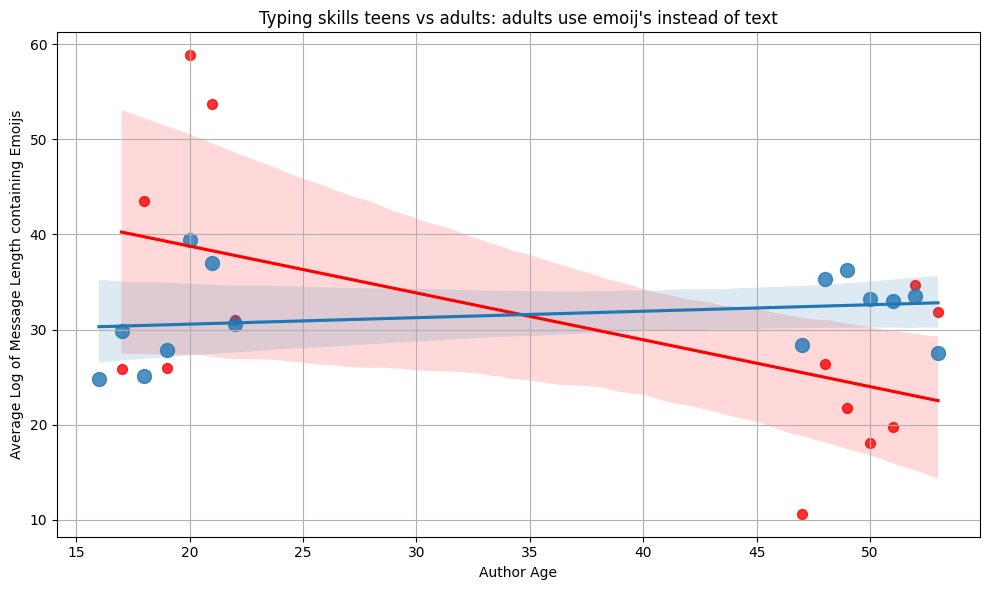

In [418]:
# Calculate the logarithm of message length
df['log_len'] = np.log(df['message_length'])

# Calculate the average log length per author
avg_log_length_withemoji = df_em.groupby('age')['message_length'].mean().reset_index()
avg_log_length_without_emoji = df_nem.groupby('age')['message_length'].mean().reset_index()

# Create the regression plot
plt.figure(figsize=(10, 6), facecolor='white')

# Regression line for average log length against age
sns.regplot(data=avg_log_length_withemoji, x='age', y='message_length', marker='o', scatter_kws={'s': 50}, color='red')
sns.regplot(data=avg_log_length_without_emoji, x='age', y='message_length', marker='o', scatter_kws={'s': 100})

# Add titles and labels
plt.title("Typing skills teens vs adults: adults use emoij's instead of text")
plt.xlabel('Author Age')
plt.ylabel('Average Log of Message Length containing Emoijs')
plt.xticks()
plt.grid()

# Adjust layout
plt.tight_layout()

# Save the plot
plt.savefig('average_log_length_vs_age.png', bbox_inches='tight', transparent=False)

# Show the plot
plt.show()

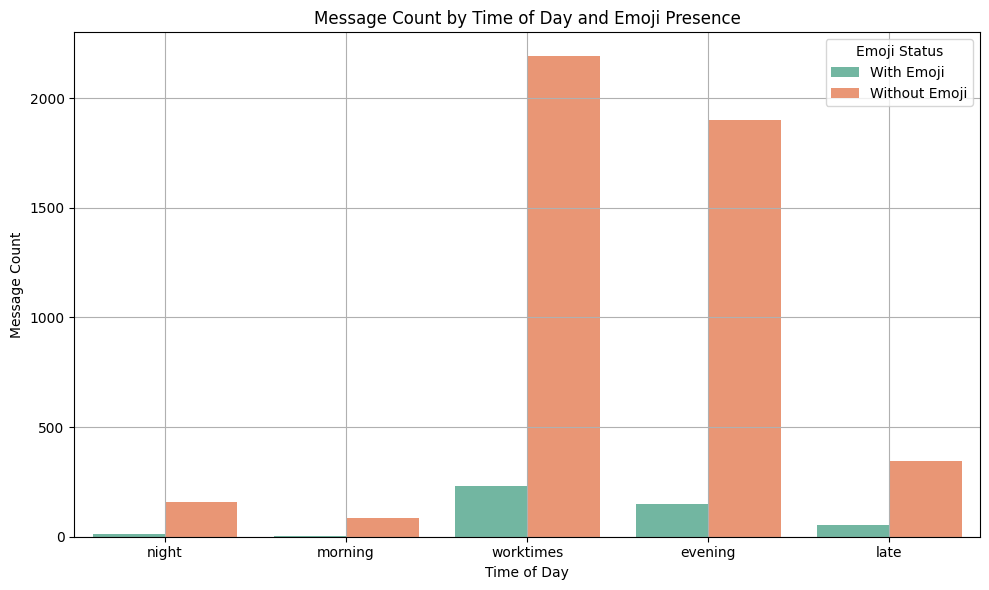

In [248]:

# Create a new column for emoji presence
df['emoji_status'] = df['has_emoji'].apply(lambda x: 'With Emoji' if x > 0 else 'Without Emoji')

# Step 1: Count occurrences for each combination of time of day and emoji presence
count_data = df.groupby(['timestamp_category', 'emoji_status']).size().reset_index(name='count')

# Step 2: Create the bar plot
plt.figure(figsize=(10, 6))
sns.barplot(data=count_data, x='timestamp_category', y='count', hue='emoji_status', palette='Set2')
plt.title('Message Count by Time of Day and Emoji Presence')
plt.xlabel('Time of Day')
plt.ylabel('Message Count')
plt.legend(title='Emoji Status')
plt.grid(True)
plt.tight_layout()

# Save the plot with an opaque background
plt.savefig('bar_plot_time_of_day_emoji.png', bbox_inches='tight', transparent=False)

# Show the plot
plt.show()


,message_length,has_emoji,count
author,,,
effervescent-camel,36.190370,0.041433,1786
hilarious-goldfinch,32.304574,0.102911,962
nimble-wombat,31.136683,0.147488,1851
spangled-rabbit,23.223464,0.013035,537


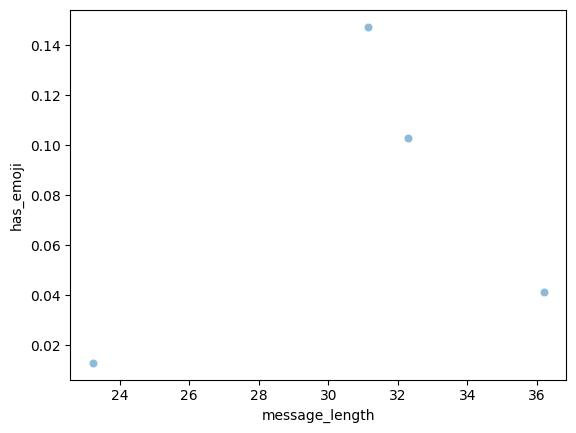

In [352]:
p = df.groupby(["author"]).agg({
    "message_length": "mean",
    "has_emoji": "mean",
    "author": "count"
    
}).rename(columns={"author": "count"})

p = p[p["count"] > 10]
sns.scatterplot(data=p, x="message_length", y="has_emoji", alpha=0.5)
p

<Axes: xlabel='message_length', ylabel='has_emoji'>

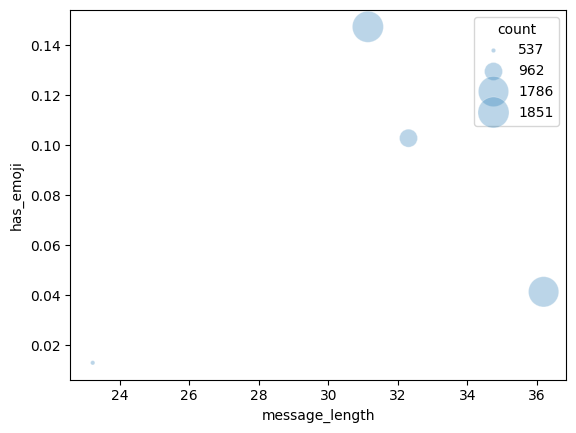

In [353]:
sns.scatterplot(data=p, x="message_length", y="has_emoji", size="count", sizes=(10, 500), alpha=0.3)

In [369]:
df_em =df[df['has_emoji']]
df_nem =df[df['has_emoji']==False]

In [370]:
p_without_emoji=df_nem.groupby(["author"]).agg({
    "message_length": "mean",
    "author": "count",
    "age": "mean",
}).rename(columns={"author": "count"})

In [371]:
p2=df_em.groupby(["author"]).agg({
    "message_length": "mean",
    "author": "count",
    "age": "mean",
    "has_emoji": "count"
}).rename(columns={"author": "count"})

In [372]:
p2

,message_length,count,age,has_emoji
author,,,,
effervescent-camel,44.581081,74,20.351351,74
hilarious-goldfinch,18.707071,99,49.949495,99
nimble-wombat,24.443223,273,50.820513,273
spangled-rabbit,18.714286,7,18.142857,7


<Axes: xlabel='age', ylabel='message_length'>

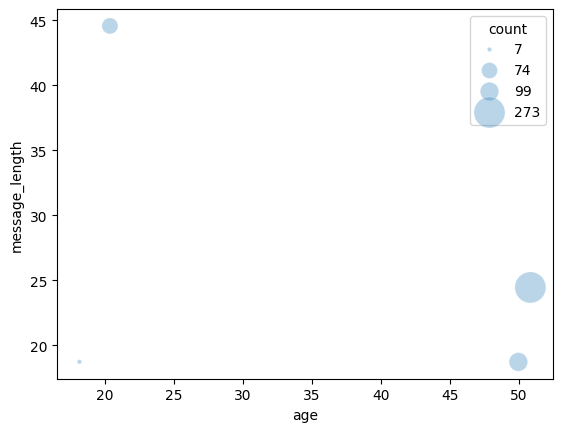

In [376]:
sns.scatterplot(data=p2, x="age", y="message_length", size="count", sizes=(10, 500), alpha=0.3)
#sns.scatterplot(data=p_without_emoji, x="age", y="message_length", size="count", sizes=(10, 500), alpha=0.3)

In [375]:
p_with_emoji =df_em.groupby(["author"]).agg({
    "message_length": "mean",
    "author": "count",
    "age": "mean"
}).rename(columns={"author": "count"})

In [338]:
p_without_emoji

,message_length,count,age,has_emoji
author,,,,
effervescent-camel,35.057377,1708,20.126464,Without Emoji
hilarious-goldfinch,31.042007,857,50.163361,Without Emoji
nimble-wombat,30.605347,1571,51.186505,Without Emoji
spangled-rabbit,22.793951,529,18.410208,Without Emoji


In [339]:
p_with_emoji['diff_length'] = p_with_emoji['message_length']- p_without_emoji['message_length']

In [340]:
p_with_emoji

,message_length,count,age,has_emoji,diff_length
author,,,,,
effervescent-camel,38.444444,72,20.347222,With Emoji,3.387067
hilarious-goldfinch,18.707071,99,49.949495,With Emoji,-12.334936
nimble-wombat,24.443223,273,50.820513,With Emoji,-6.162123
spangled-rabbit,18.714286,7,18.142857,With Emoji,-4.079665


<Axes: xlabel='age', ylabel='count'>

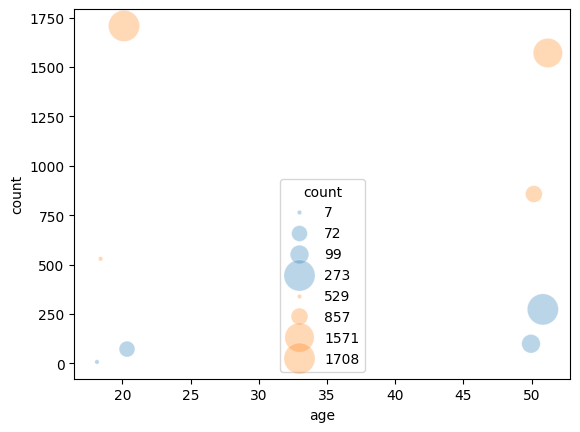

In [337]:
sns.scatterplot(data=p_with_emoji, x="age", y="count", size="count",  sizes=(10, 500), alpha=0.3)
sns.scatterplot(data=p_without_emoji, x="age", y="count", size="count", sizes=(10, 500), alpha=0.3)

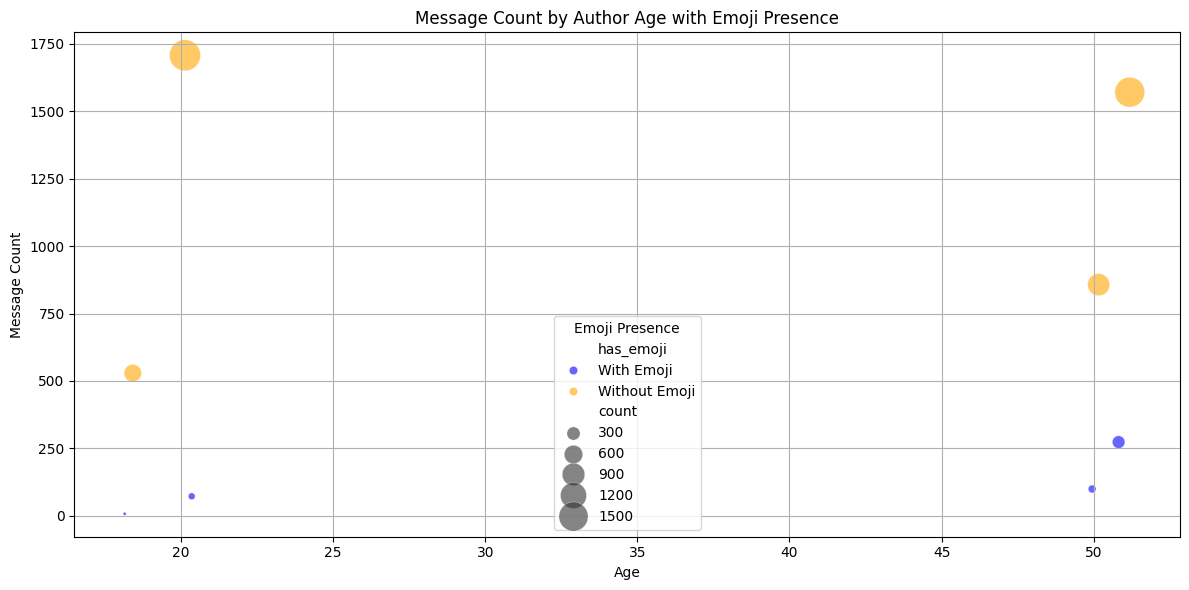

In [333]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming p_with_emoji and p_without_emoji are already created

# Add a column to indicate emoji presence
p_with_emoji['has_emoji'] = 'With Emoji'
p_without_emoji['has_emoji'] = 'Without Emoji'

# Concatenate the two DataFrames
combined_data = pd.concat([p_with_emoji, p_without_emoji])

# Create the scatter plot
plt.figure(figsize=(12, 6))
sns.scatterplot(data=combined_data, x="age", y="count", 
                size="count", sizes=(5, 500), alpha=0.6, 
                hue='has_emoji', palette={'With Emoji': 'blue', 'Without Emoji': 'orange'})

# Add titles and labels
plt.title('Message Count by Author Age with Emoji Presence')
plt.xlabel('Age')
plt.ylabel('Message Count')

# Add a legend and grid
plt.legend(title='Emoji Presence')
plt.grid()

# Show the plot
plt.tight_layout()
plt.show()


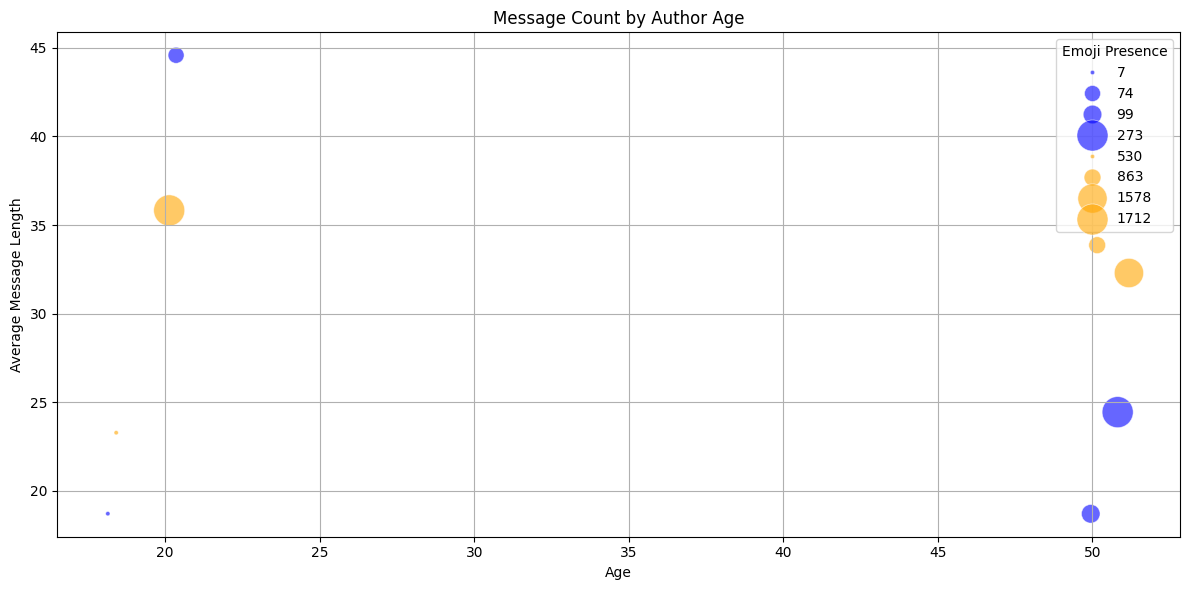

In [388]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate aggregated data for authors with emojis
p_with_emoji = df_em.groupby(["author"]).agg({
    "message_length": "mean",
    "author": "count",
    "age": "mean"
}).rename(columns={"author": "count"})

# Calculate aggregated data for authors without emojis
p_without_emoji = df_nem.groupby(["author"]).agg({
    "message_length": "mean",
    "author": "count",
    "age": "mean"
}).rename(columns={"author": "count"})

# Create the scatter plot
plt.figure(figsize=(12, 6))

# Scatter plot for authors with emojis
sns.scatterplot(data=p_with_emoji, x="age", y="message_length", 
                size="count", sizes=(10, 500), alpha=0.6, 
                color='blue')

# Scatter plot for authors without emojis
sns.scatterplot(data=p_without_emoji, x="age", y="message_length", 
                size="count", sizes=(10, 500), alpha=0.6, 
                color='orange')

# Add titles and labels
plt.title('Message Count by Author Age')
plt.xlabel('Age')
plt.ylabel('Average Message Length')

# Add a legend
plt.legend(title='Emoji Presence')

# Show grid and layout
plt.grid()
plt.tight_layout()
plt.show()


In [259]:
df_em.groupby(["author"]).agg({
    "message_length": "mean",
    "author": "count",
    "age": "mean"
}).rename(columns={"author": "count"})

,message_length,count,age
author,,,
effervescent-camel,44.581081,74,20.351351
hilarious-goldfinch,18.707071,99,49.949495
nimble-wombat,24.443223,273,50.820513
spangled-rabbit,18.714286,7,18.142857


In [258]:
df.groupby(["author"]).agg({
    "message_length": "mean",
    "author": "count",
    "age": "mean"
}).rename(columns={"author": "count"})

,message_length,count,age
author,,,
effervescent-camel,36.190370,1786,20.137738
hilarious-goldfinch,32.304574,962,50.136175
nimble-wombat,31.136683,1851,51.131821
spangled-rabbit,23.223464,537,18.409683


In [253]:
p2 = df.groupby(["author"]).agg({
    "message_length": "mean",
    "author": "count"
}).rename(columns={"author": "count"})

<Axes: xlabel='message_length', ylabel='count'>

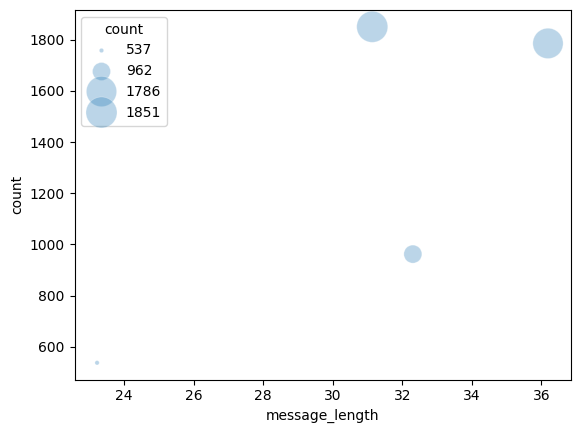

In [255]:
sns.scatterplot(data=p, x="message_length", y="count", size="count", sizes=(10, 500), alpha=0.3)

In [378]:
p["message_length"] /= p["message_length"].max()
p["has_emoji"] /= p["has_emoji"].max()
p["color"] = p.apply(lambda x: "grey" if x["message_length"] > x["has_emoji"] else "red", axis=1)

p

,message_length,has_emoji,count,color
author,,,,
effervescent-camel,1.000000,0.280927,1786,grey
hilarious-goldfinch,0.892629,0.697757,962,grey
nimble-wombat,0.860358,1.000000,1851,red
spangled-rabbit,0.641703,0.088383,537,grey


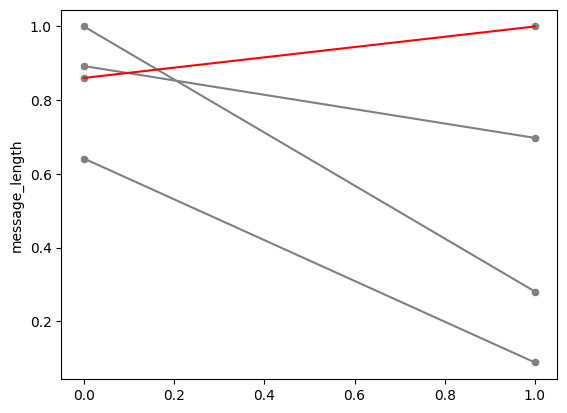

In [379]:
sns.scatterplot(data=p, y="message_length", x=0, color="grey")
sns.scatterplot(data=p, y="has_emoji", x=1, color="grey")
for index, row in p.iterrows():
    sns.lineplot(x=[0, 1], y=[row["message_length"], row["has_emoji"]], color=row["color"])

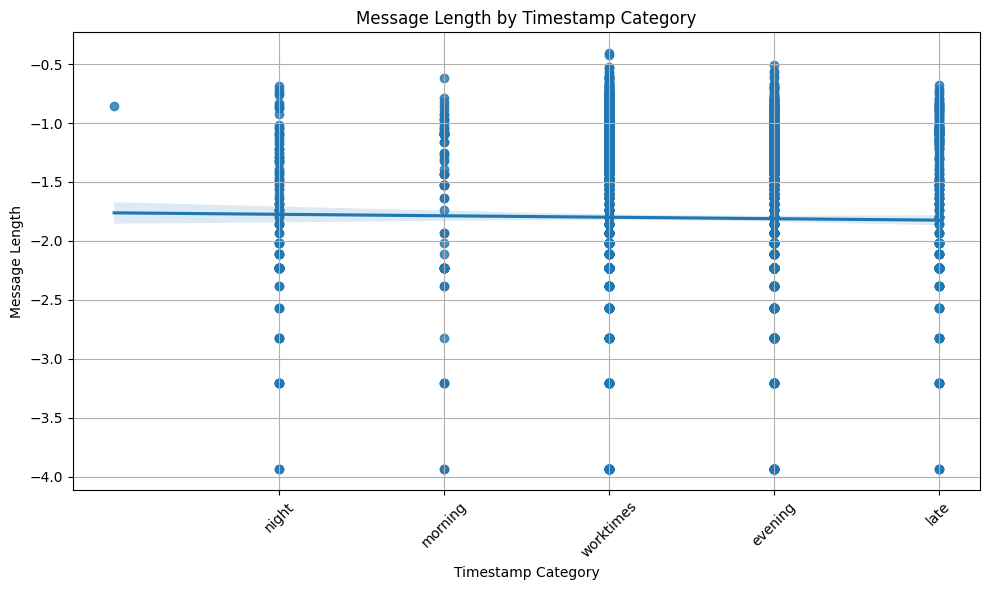

In [161]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Sample data (adjust this to use your actual DataFrame)
data = {
    #'message_length': df["message_length"].apply(lambda x: np.log(x)),
    'message_length': df["message_length"],
    'timestamp_category': df['timestamp_category'],
    'author': df['author']
}

# Create DataFrame
df = pd.DataFrame(data)

# Convert 'timestamp_category' to categorical and then to numeric
df['timestamp_category'] = pd.Categorical(df['timestamp_category'])
df['timestamp_category_code'] = df['timestamp_category'].cat.codes

# Create the regression plot using lmplot
plt.figure(figsize=(10, 6))
sns.regplot(x='timestamp_category_code', y='message_length', data=df,
          )

# Customize x-ticks to show original category names
plt.xticks(ticks=range(len(df['timestamp_category'].cat.categories)),
           labels=df['timestamp_category'].cat.categories, rotation=45)

# Adding titles and labels
plt.title('Message Length by Timestamp Category')
plt.xlabel('Timestamp Category')
plt.ylabel('Message Length')

# Show the plot
plt.grid()
plt.tight_layout()
plt.show()



In [74]:
p.reset_index()
p.columns

Index(['message_length', 'has_emoji', 'count'], dtype='object')

In [61]:
df_em['hour'].value_counts().sort_index()

hour
0.250000     1
0.300000     1
0.383333     1
1.033333     2
1.116667     1
            ..
23.716667    1
23.766667    1
23.866667    1
23.933333    1
23.983333    1
Name: count, Length: 326, dtype: int64

In [45]:
#df_em[df_em['timestamp_category']=='late']

In [111]:
# Calculate the average presence of emojis by time category
average_emoji = df.groupby('hour')['has_emoji'].mean().reset_index()
average_emoji = average_emoji.sort_values(by='has_emoji', ascending=False)
average_emoji

,hour,has_emoji
249,10:36:00,1.0
242,10:28:00,1.0
328,12:05:00,1.0
867,21:21:00,1.0
886,21:41:00,1.0
...,...,...
1006,23:53:00,0.0
1007,23:54:00,0.0
237,10:20:00,0.0
1009,23:57:00,0.0


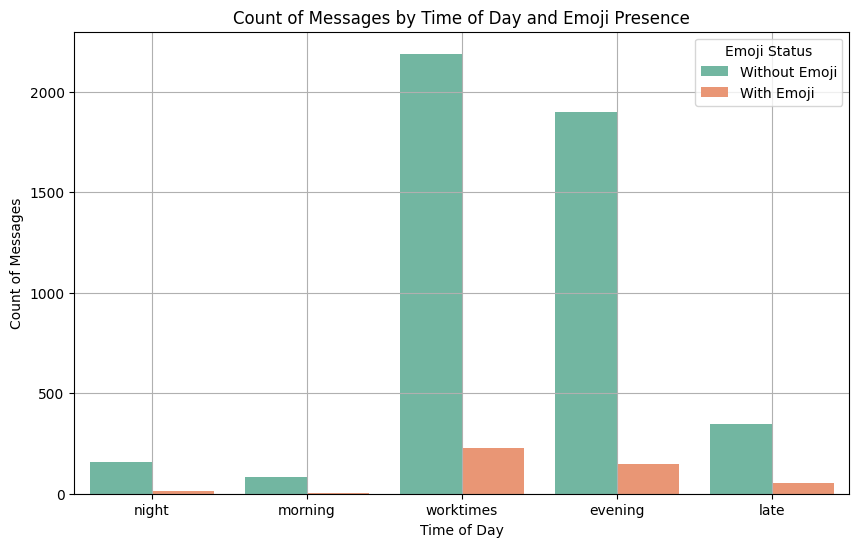

In [186]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt



# Convert emoji presence to categorical
df['emoji_status'] = df['has_emoji'].apply(lambda x: 'With Emoji' if x > 0 else 'Without Emoji')

# Step 1: Create the count plot
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='timestamp_category', hue='emoji_status', palette='Set2')

# Customize the plot
plt.title('Count of Messages by Time of Day and Emoji Presence')
plt.xlabel('Time of Day')
plt.ylabel('Count of Messages')
plt.legend(title='Emoji Status')
plt.grid(True)

# Save the plot with an opaque background
plt.savefig('count_plot_time_of_day_emoji.png', bbox_inches='tight', transparent=False)

# Show the plot
plt.show()


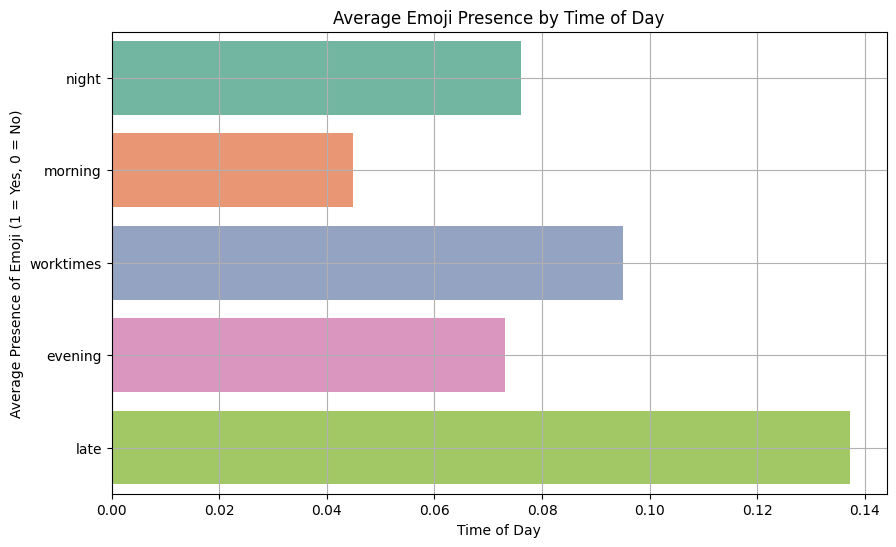

In [128]:
#df[df['has_emoij']]['hour'].value_counts().sort_index(),

df_counts2 = pd.DataFrame(data).reindex(range(24), fill_value=0).fillna(0)

# Step 2: Create the bar plot
plt.figure(figsize=(10, 6))
sns.barplot(data=average_emoji, y='timestamp_category', x='has_emoji', palette='Set2')

# Customize the plot
plt.title('Average Emoji Presence by Time of Day')
plt.xlabel('Time of Day')
plt.ylabel('Average Presence of Emoji (1 = Yes, 0 = No)')
plt.grid(True)

# Save the plot with an opaque background
#plt.savefig('bar_plot_average_emoji_presence.png', bbox_inches='tight', transparent=False)

# Show the plot
plt.show()

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df_counts2 is defined and contains your data
# Step 2: Melt the DataFrame
#df_melted = pd.melt(df_counts2, id_vars=['hour'], var_name='Category', value_name='Count')

# Step 3: Calculate total counts for each hour and normalize as a percentage
#df_melted['Total'] = df_melted.groupby('hour')['Count'].transform('sum')
#df_melted['Percentage'] = df_melted['Count'] / df_melted['Total'] 

# Filter for a specific category, e.g., 'Food'
df_food = df_melted[df_melted['Category'] == 'Plans']

# Step 4: Create a regplot for the 'Food' category
plt.figure(figsize=(12, 6))
sns.regplot(data=df_food, x='hour', y='Percentage', scatter_kws={'color': 'red'}, line_kws={'color': 'black'})
plt.title('Regression of Food Percentage Over Hours')
plt.xlabel('Hour of the Day')
plt.ylabel('Percentage of Total Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

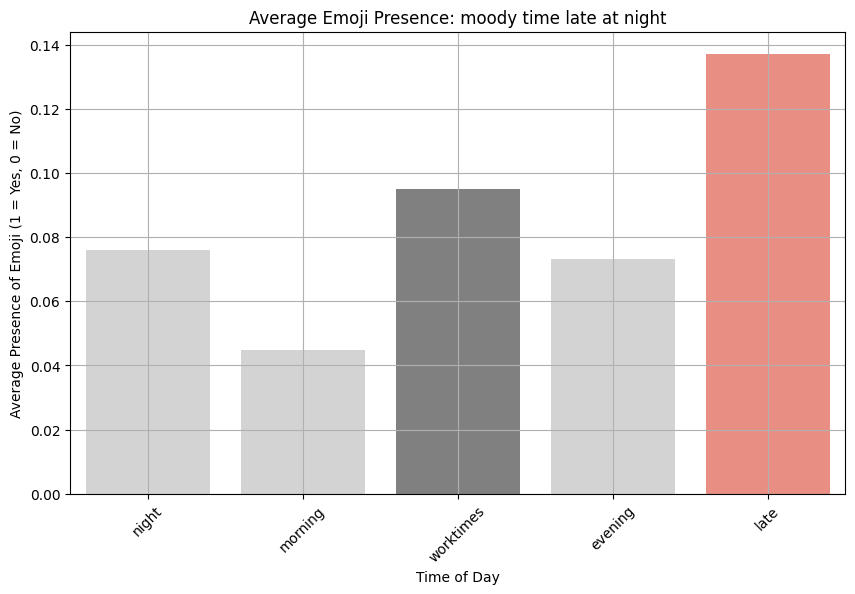

In [166]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Calculate the average presence of emojis by time category
average_emoji = df.groupby('timestamp_category')['has_emoji'].mean().reset_index()

# Sort the DataFrame in descending order based on average emoji presence
average_emoji = average_emoji.sort_values(by='has_emoji', ascending=True)

# Step 2: Create the bar plot
plt.figure(figsize=(10, 6))
colors = ['lightgray', 'lightgray', 'gray', 'lightgray', 'salmon']
sns.barplot(data=average_emoji, x='timestamp_category', y='has_emoji', palette=colors)

# Customize the plot
plt.title('Average Emoji Presence: moody time late at night')
plt.xlabel('Time of Day')
plt.ylabel('Average Presence of Emoji (1 = Yes, 0 = No)')
plt.xticks(rotation=45)  # Rotate x-axis labels if needed
plt.grid(True)

# Save the plot with an opaque background
plt.savefig('bar_plot_average_emoji_presence.png', bbox_inches='tight', transparent=False)

# Show the plot
plt.show()


In [189]:
average_emoji

,author,has_emoji
3,spangled-rabbit,0.013035
0,effervescent-camel,0.041433
1,hilarious-goldfinch,0.102911
2,nimble-wombat,0.147488


C:\Users\Francesca\AppData\Local\Temp\ipykernel_38432\976573939.py:15: UserWarning: The palette list has more values (5) than needed (4), which may not be intended.
  sns.barplot(data=average_emoji, x='author', y='message_length', palette=colors)


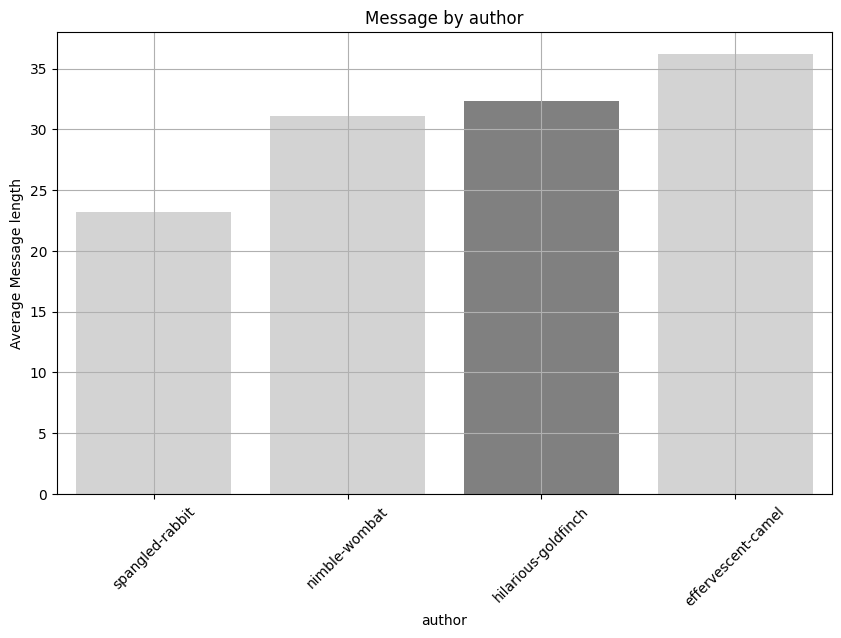

In [193]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Calculate the average presence of emojis by time category
average_emoji = df.groupby('author')['message_length'].mean().reset_index()

# Sort the DataFrame in descending order based on average emoji presence
average_emoji = average_emoji.sort_values(by='message_length', ascending=True)

# Step 2: Create the bar plot
plt.figure(figsize=(10, 6))
colors = ['lightgray', 'lightgray', 'gray', 'lightgray', 'salmon']
sns.barplot(data=average_emoji, x='author', y='message_length', palette=colors)

# Customize the plot
plt.title('Message by author')
plt.xlabel('author')
plt.ylabel('Average Message length')
plt.xticks(rotation=45)  # Rotate x-axis labels if needed
plt.grid(True)

# Save the plot with an opaque background
plt.savefig('bar_plot_average_emoji_presence.png', bbox_inches='tight', transparent=False)

# Show the plot
plt.show()

In [392]:
# Create a new column to categorize messages based on emoji presence
df['emoji_status'] = df['has_emoji'].apply(lambda x: 'With Emoji' if x > 0 else 'Without Emoji')

# Sort the DataFrame by author
df_sorted = df.sort_values(by='author')

# Split into separate DataFrames
df_with_emojis = df_sorted[df_sorted['emoji_status'] == 'With Emoji']
df_without_emojis = df_sorted[df_sorted['emoji_status'] == 'Without Emoji']

# Ensure both DataFrames have the same order of authors
common_authors = df_sorted['author'].unique()

df_with_emojis['author'] = pd.Categorical(df_with_emojis['author'], categories=common_authors, ordered=True)
df_without_emojis['author'] = pd.Categorical(df_without_emojis['author'], categories=common_authors, ordered=True)
df_with_emojis

C:\Users\Francesca\AppData\Local\Temp\ipykernel_38432\2145620837.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_with_emojis['author'] = pd.Categorical(df_with_emojis['author'], categories=common_authors, ordered=True)
C:\Users\Francesca\AppData\Local\Temp\ipykernel_38432\2145620837.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_without_emojis['author'] = pd.Categorical(df_without_emojis['author'], categories=common_authors, ordered=True)


,timestamp,message,author,has_emoji,is_topk,message_length,has_link,timestamp_category,hour,day_of_week,language,date,isoweek,year-week,topic,log_len,year,age,emoji_status
3265,2023-10-02 08:59:00,dussssss ik ga een general management stage lo...,effervescent-camel,True,True,57,False,worktimes,8.983333,0,NL,2023-10-02,40,2023-40,None,4.043051,2023,21,With Emoji
3315,2023-10-26 12:31:00,heeft hij nou een winactie gedaan voor de fiet...,effervescent-camel,True,True,92,False,worktimes,12.516667,3,NL,2023-10-26,43,2023-43,None,4.521789,2023,21,With Emoji
1388,2022-05-15 12:32:00,oké 👍🏻,effervescent-camel,True,True,9,False,worktimes,12.533333,6,NL,2022-05-15,19,2022-19,None,2.197225,2022,20,With Emoji
1384,2022-05-15 11:08:00,hoelaat 😂,effervescent-camel,True,True,13,False,worktimes,11.133333,6,NL,2022-05-15,19,2022-19,None,2.564949,2022,20,With Emoji
3079,2023-08-12 19:09:00,😂,effervescent-camel,True,True,4,False,evening,19.150000,5,Non-verbal,2023-08-12,32,2023-32,None,1.386294,2023,21,With Emoji
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3620,2024-02-25 13:49:00,dat is lariekoek 🤡,spangled-rabbit,True,True,21,False,worktimes,13.816667,6,NL,2024-02-25,8,2024-08,None,3.044522,2024,20,With Emoji
2554,2023-05-30 12:12:00,"verdorie, wat gaaf! 😜",spangled-rabbit,True,True,24,False,worktimes,12.200000,1,NL,2023-05-30,22,2023-22,None,3.178054,2023,19,With Emoji
623,2021-08-14 14:48:00,ja komt goed 👍,spangled-rabbit,True,True,17,False,worktimes,14.800000,5,NL,2021-08-14,32,2021-32,None,2.833213,2021,17,With Emoji
4082,2021-09-14 17:54:00,indonesisch bestellen ✅,spangled-rabbit,True,True,26,False,evening,17.900000,1,NL,2021-09-14,37,2021-37,food,3.258097,2021,17,With Emoji


In [393]:
# Create a new column to categorize messages based on emoji presence
df['emoji_status'] = df['has_emoji'].apply(lambda x: 'With Emoji' if x > 0 else 'Without Emoji')

# Sort the DataFrame by author
df_sorted = df.sort_values(by='author')

# Split into separate DataFrames
df_with_emojis = df_sorted[df_sorted['emoji_status'] == 'With Emoji']
df_without_emojis = df_sorted[df_sorted['emoji_status'] == 'Without Emoji']

# Ensure both DataFrames have the same order of authors
common_authors = df_sorted['author'].unique()

df_with_emojis['author'] = pd.Categorical(df_with_emojis['author'], categories=common_authors, ordered=True)
df_without_emojis['author'] = pd.Categorical(df_without_emojis['author'], categories=common_authors, ordered=True)

# Create a FacetGrid
g = sns.FacetGrid(df_sorted, col='emoji_status', hue='gender', height=5, aspect=1.5, palette={'F': 'skyblue', 'M': 'salmon'})

# Map the scatter plot to each facet
g.map(sns.scatterplot,  'author', 'log_len', s=100)

# Add count annotations
for ax in g.axes.flat:
    # Get the title to determine the emoji status
    emoji_status = ax.get_title().split(' ')[0]  # "With" or "Without"
    
    # Filter the DataFrame based on the emoji status
    for i in range(df_sorted.shape[0]):
        if df_sorted['emoji_status'].iloc[i] == emoji_status:
            ax.text(df_sorted['log_len'].iloc[i], df_sorted['author'].iloc[i], df_sorted['count'].iloc[i], 
                    fontsize=9, ha='right', va='center', alpha=0.7)

# Add titles and labels
g.set_axis_labels('Log of Message Length', 'Author')
g.set_titles(col_template='{col_name}')

# Add a legend
g.add_legend()

# Adjust layout
plt.subplots_adjust(top=0.85)
g.fig.suptitle('Scatter Plot of Authors by Log of Message Length and Emoji Presence with Count Annotations')
plt.show()


C:\Users\Francesca\AppData\Local\Temp\ipykernel_38432\2305516422.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_with_emojis['author'] = pd.Categorical(df_with_emojis['author'], categories=common_authors, ordered=True)
C:\Users\Francesca\AppData\Local\Temp\ipykernel_38432\2305516422.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_without_emojis['author'] = pd.Categorical(df_without_emojis['author'], categories=common_authors, ordered=True)


KeyError: 'gender'

In [404]:
df

,timestamp,message,author,has_emoji,is_topk,message_length,has_link,timestamp_category,hour,day_of_week,language,date,isoweek,year-week,topic,log_len,year,age
0,2018-12-11 11:21:00,hoi,effervescent-camel,False,True,6,False,worktimes,11.350000,1,NL,2018-12-11,50,2018-50,None,1.791759,2018,16
1,2018-12-11 11:21:00,kijk wat ik heb gevonden,effervescent-camel,False,True,27,False,worktimes,11.350000,1,NL,2018-12-11,50,2018-50,None,3.295837,2018,16
2,2018-12-11 11:21:00,<media weggelaten>,effervescent-camel,False,True,21,False,worktimes,11.350000,1,Non-verbal,2018-12-11,50,2018-50,None,3.044522,2018,16
3,2018-12-11 11:21:00,<media weggelaten>,effervescent-camel,False,True,21,False,worktimes,11.350000,1,Non-verbal,2018-12-11,50,2018-50,None,3.044522,2018,16
4,2018-12-11 11:21:00,<media weggelaten>,effervescent-camel,False,True,21,False,worktimes,11.350000,1,Non-verbal,2018-12-11,50,2018-50,None,3.044522,2018,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5131,2024-06-23 20:25:00,effervescent-camel,hilarious-goldfinch,False,True,15,False,evening,20.416667,6,NL,2024-06-23,25,2024-25,people,2.708050,2024,52
5132,2024-06-23 20:26:00,ontwerp van spangled-rabbit: https://www.ikea....,hilarious-goldfinch,False,True,115,True,evening,20.433333,6,Non-verbal,2024-06-23,25,2024-25,people,4.744932,2024,52
5133,2024-06-23 20:30:00,design code effervescent-camel: qsvslg,hilarious-goldfinch,False,True,28,False,evening,20.500000,6,NL,2024-06-23,25,2024-25,people,3.332205,2024,52
5134,2024-06-24 11:36:00,effervescent-camel hoe gaat het,nimble-wombat,False,True,29,False,worktimes,11.600000,0,NL,2024-06-24,26,2024-26,people,3.367296,2024,53


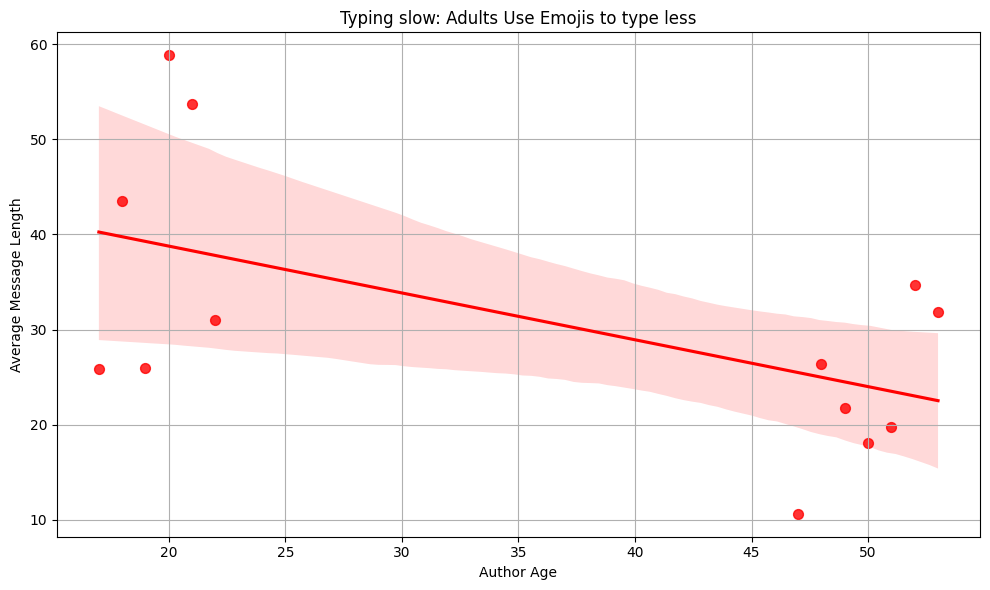

In [434]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df, df_em, and df_nem are already defined

# Calculate the average message length per age
avg_log_length_withemoji = df_em.groupby('age')['message_length'].mean().reset_index()
avg_log_length_without_emoji = df_nem.groupby('age')['message_length'].mean().reset_index()

# Create the regression plot
plt.figure(figsize=(10, 6), facecolor='white')

# Regression line for average length against age
line_with_emoji = sns.regplot(data=avg_log_length_withemoji, x='age', y='message_length', 
                               marker='o', scatter_kws={'s': 50}, color='red', label='With Emojis')
#line_without_emoji = sns.regplot(data=avg_log_length_without_emoji, x='age', y='message_length', 
#                                   marker='o', scatter_kws={'s': 10}, color='gray', label='Without Emojis')

# Add titles and labels
plt.title("Typing slow: Adults Use Emojis to type less")
plt.xlabel('Author Age')
plt.ylabel('Average Message Length')
plt.xticks()
plt.grid()



# Adjust layout
plt.tight_layout()

# Save the plot
plt.savefig('average_message_length_vs_age.png', bbox_inches='tight', transparent=False)

# Show the plot
plt.show()


In [91]:
# Create synthetic data
np.random.seed(0)
author_ages = np.random.randint(13, 50, 100)  # Random ages between 13 and 50
message_lengths = author_ages * 2 + np.random.normal(0, 5, 100)  # Lengths with some noise
author_ages

array([13, 16, 16, 22, 32, 34, 49, 36, 19, 37, 37, 25, 14, 36, 37, 30, 38,
       26, 21, 22, 33, 29, 18, 28, 13, 31, 48, 37, 42, 32, 32, 27, 45, 14,
       22, 45, 44, 23, 36, 48, 24, 41, 47, 13, 13, 49, 18, 30, 28, 17, 44,
       14, 14, 48, 24, 31, 40, 13, 27, 48, 25, 33, 24, 17, 19, 17, 16, 25,
       49, 27, 28, 33, 48, 36, 28, 26, 34, 18, 48, 13, 44, 18, 43, 13, 49,
       47, 42, 16, 47, 26, 34, 22, 13, 23, 36, 15, 47, 48, 43, 16],
      dtype=int32)

In [95]:
df['age'] = 


,timestamp,message,author,has_emoji,is_topk,message_length,has_link,timestamp_category,hour,day_of_week,language,date,isoweek,year-week
0,2018-12-11 11:21:00,hoi,effervescent-camel,False,True,6,False,worktimes,11:21:00,1,NL,2018-12-11,50,2018-50
1,2018-12-11 11:21:00,kijk wat ik heb gevonden,effervescent-camel,False,True,27,False,worktimes,11:21:00,1,NL,2018-12-11,50,2018-50
2,2018-12-11 11:21:00,<media weggelaten>,effervescent-camel,False,True,21,False,worktimes,11:21:00,1,Non-verbal,2018-12-11,50,2018-50
3,2018-12-11 11:21:00,<media weggelaten>,effervescent-camel,False,True,21,False,worktimes,11:21:00,1,Non-verbal,2018-12-11,50,2018-50
4,2018-12-11 11:21:00,<media weggelaten>,effervescent-camel,False,True,21,False,worktimes,11:21:00,1,Non-verbal,2018-12-11,50,2018-50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5131,2024-07-04 03:20:00,verder alles goed!,effervescent-camel,False,True,21,False,night,03:20:00,3,NL,2024-07-04,27,2024-27
5132,2024-07-04 07:25:00,https://www.udinetoday.it/cronaca/navetta-grat...,nimble-wombat,False,True,64,True,morning,07:25:00,3,Non-verbal,2024-07-04,27,2024-27
5133,2024-07-04 13:59:00,<media weggelaten>,hilarious-goldfinch,False,True,21,False,worktimes,13:59:00,3,Non-verbal,2024-07-04,27,2024-27
5134,2024-07-04 14:14:00,<media weggelaten>,nimble-wombat,False,True,21,False,worktimes,14:14:00,3,Non-verbal,2024-07-04,27,2024-27


In [92]:
df2 = 

,Author Age,Message Length
0,13,29.099005
1,16,40.955842
2,16,32.855002
3,22,35.371643
4,32,64.803293
...,...,...
95,15,37.453610
96,47,94.977497
97,48,93.641978
98,43,95.061773


In [205]:
df_emj= df[df['has_emoji']]
df_emj['age']

6       47
9       48
11      17
12      48
23      47
        ..
5049    51
5093    21
5117    53
5118    53
5124    53
Name: age, Length: 453, dtype: int64

In [206]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



# Create a DataFrame
df_ages = pd.DataFrame({
    'Author Age': df_emj[df_emj['age']<30],
    'Message Length': df_emj['message_length']
})

# Create the regression plot
plt.figure(figsize=(10, 6), facecolor='white')

# Regression line for message lengths against author ages
sns.regplot(data=df_ages, x='Author Age', y='Message Length', marker='o', scatter_kws={'s': 100})

# Add titles and labels
plt.title("Message Length vs. Author Age")
plt.xlabel('Author Age')
plt.ylabel('Message Length')
plt.grid()

# Adjust layout
plt.tight_layout()

# Save the plot
plt.savefig('message_length_vs_author_age.png', bbox_inches='tight', transparent=False)

# Show the plot
plt.show()


ValueError: 2

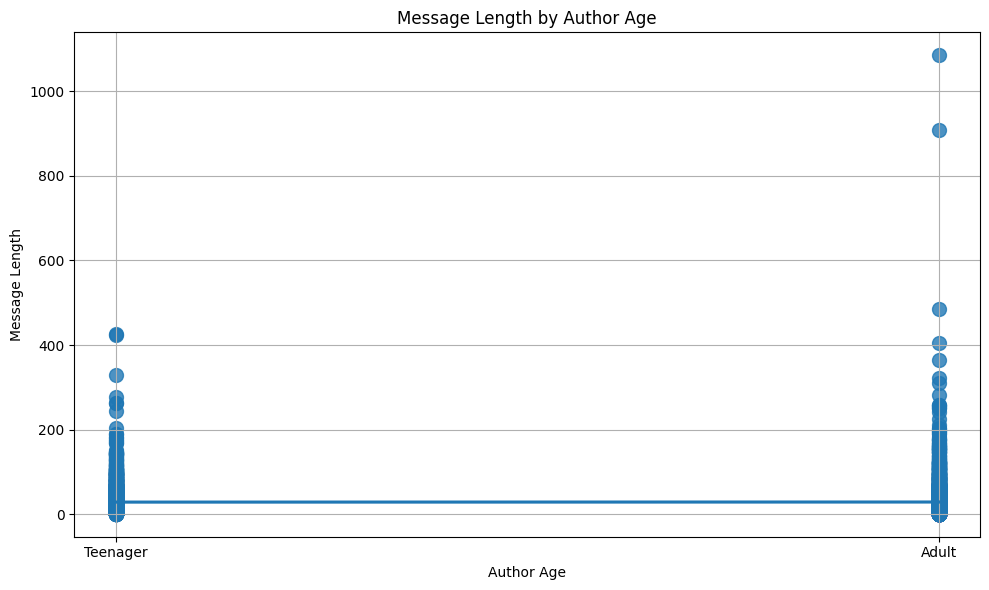

In [85]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Sample DataFrame setup (assuming df is already defined with relevant columns)
# df = pd.DataFrame(...)  # Your DataFrame goes here

# Assign categories to each author
category_mapping = {
    'effervescent-camel': 'teenager',
    'hilarious-goldfinch': 'adult',
    'nimble-wombat': 'adult',
    'spangled-rabbit': 'teenager'
}
df['category'] = df['author'].map(category_mapping)

# Calculate the length of messages
df['message_length'] = df['message'].str.len()  # Adjust this based on how your messages are structured

# Map authors to a numerical age value for plotting
age_mapping = {
    'teenager': 15,  # Example age for teenagers
    'adult': 30      # Example age for adults
}
df['age'] = df['category'].map(age_mapping)

# Create the regression plot
plt.figure(figsize=(10, 6), facecolor='white')

# Regression line for message length against author age
sns.regplot(data=df, x='age', y='message_length', marker='o', scatter_kws={'s': 100})

# Add titles and labels
plt.title("Message Length by Author Age")
plt.xlabel('Author Age')
plt.ylabel('Message Length')
plt.xticks(ticks=[15, 30], labels=['Teenager', 'Adult'])
plt.grid()

# Adjust layout
plt.tight_layout()

# Save the plot
plt.savefig('message_length_vs_age.png', bbox_inches='tight', transparent=False)

# Show the plot
plt.show()


<Figure size 800x600 with 0 Axes>

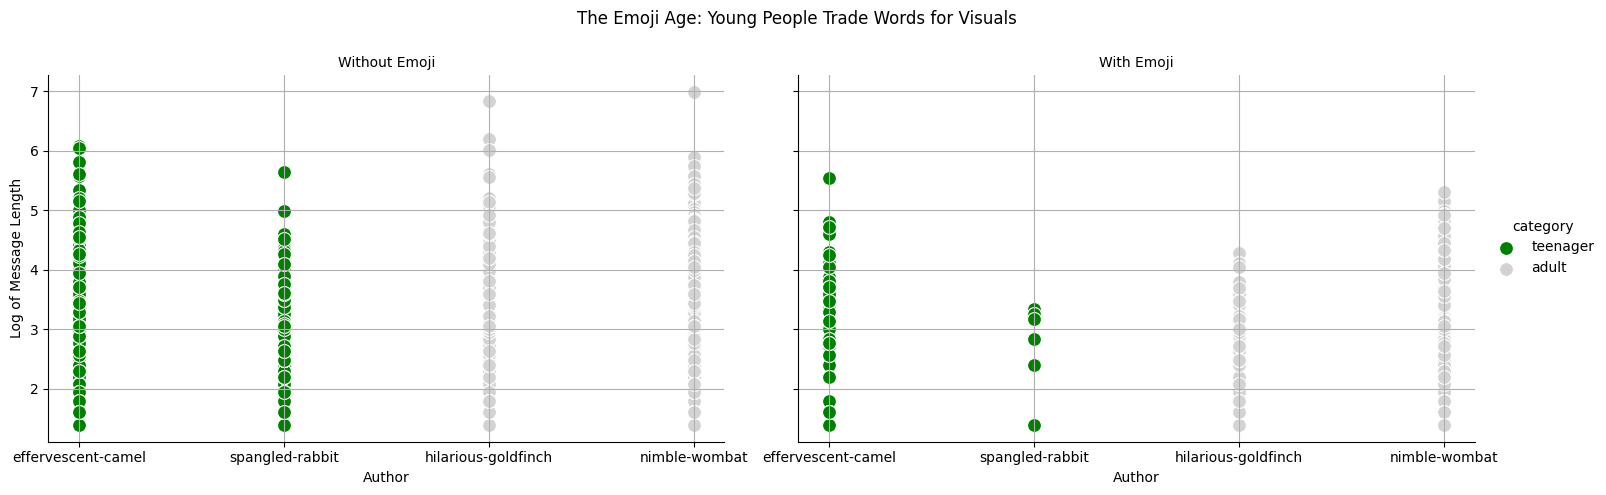

In [12]:
# Assign categories to each author
category_mapping = {
    'effervescent-camel': 'teenager',
    'hilarious-goldfinch': 'adult',
    'nimble-wombat': 'adult',
    'spangled-rabbit': 'teenager'
}
df['category'] = df['author'].map(category_mapping)

# Calculate the logarithm of message length
df['log_len'] = np.log(df['message_length'])

# Create a new column to categorize messages based on emoji presence
df['emoji_status'] = df['has_emoji'].apply(lambda x: 'With Emoji' if x > 0 else 'Without Emoji')

# Sort the DataFrame by author
df_sorted = df.sort_values(by='author')

# Create the scatter plot
plt.figure(figsize=(8, 6), facecolor='white')  
# Create a FacetGrid
g = sns.FacetGrid(df_sorted, col='emoji_status', hue='category', height=5, aspect=1.5, palette={'teenager': 'green', 'adult': 'lightgray'})

# Map the scatter plot to each facet (note that x and y are swapped)
g.map(sns.scatterplot, 'author', 'log_len', s=100)

# Add count annotations
for ax in g.axes.flat:
    # Get the title to determine the emoji status
    emoji_status = ax.get_title().split(' ')[0]  # "With" or "Without"
    
    # Filter the DataFrame based on the emoji status
    for i in range(df_sorted.shape[0]):
        if df_sorted['emoji_status'].iloc[i] == emoji_status:
            ax.text(df_sorted['author'].iloc[i], df_sorted['log_len'].iloc[i], df_sorted['count'].iloc[i], 
                    fontsize=9, ha='right', va='center')

    # Add grid to the axes
    ax.grid(True)

# Add titles and labels
g.set_axis_labels('Author', 'Log of Message Length')
g.set_titles(col_template='{col_name}')

# Add a legend
g.add_legend()

# Adjust layout
plt.subplots_adjust(top=0.85)
g.fig.suptitle("The Emoji Age: Young People Trade Words for Visuals")
plt.grid(True)

# Save the plot
#plt.savefig('4_scatter_plot_with_emojis.png', bbox_inches='tight', transparent=False)  # Save after all plotting commands

# Save the plot with an opaque background
plt.savefig('4_scatter_plot_with_emojis.png', bbox_inches='tight', transparent=False)
# Show the plot
plt.show()

In [87]:
# Assign categories to each author
category_mapping = {
    'effervescent-camel': 'teenager',
    'hilarious-goldfinch': 'adult',
    'nimble-wombat': 'adult',
    'spangled-rabbit': 'teenager'
}
df['category'] = df['author'].map(category_mapping)

# Calculate the logarithm of message length
df['log_len'] = np.log(df['message_length'])

# Create a new column to categorize messages based on emoji presence
df['emoji_status'] = df['has_emoji'].apply(lambda x: 'With Emoji' if x > 0 else 'Without Emoji')

# Sort the DataFrame by author
df_sorted = df.sort_values(by='author')
df_sorted

,timestamp,message,author,has_emoji,is_topk,message_length,has_link,timestamp_category,hour,day_of_week,language,date,isoweek,year-week,log_len,category,emoji_status,age
0,2018-12-11 11:21:00,hoi,effervescent-camel,False,True,3,False,worktimes,11.350000,1,NL,2018-12-11,50,2018-50,1.098612,teenager,Without Emoji,15
3744,2023-08-03 12:00:00,soms halen ze dat in,effervescent-camel,False,True,20,False,worktimes,12.000000,3,IT,2023-08-03,31,2023-31,2.995732,teenager,Without Emoji,15
3745,2023-08-03 12:00:00,app maar gewoon als je vertrekt,effervescent-camel,False,True,31,False,worktimes,12.000000,3,NL,2023-08-03,31,2023-31,3.433987,teenager,Without Emoji,15
3747,2023-08-03 12:01:00,en als je vlucht nummer stuurt kunnen we dat v...,effervescent-camel,False,True,51,False,worktimes,12.016667,3,NL,2023-08-03,31,2023-31,3.931826,teenager,Without Emoji,15
1217,2021-11-10 14:01:00,en eet dan ook niet mee 😂,effervescent-camel,True,True,25,False,worktimes,14.016667,2,NL,2021-11-10,45,2021-45,3.218876,teenager,With Emoji,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3842,2023-08-10 12:10:00,<media weggelaten>,spangled-rabbit,False,True,18,False,worktimes,12.166667,3,Non-verbal,2023-08-10,32,2023-32,2.890372,teenager,Without Emoji,15
3843,2023-08-10 12:13:00,<media weggelaten>,spangled-rabbit,False,True,18,False,worktimes,12.216667,3,Non-verbal,2023-08-10,32,2023-32,2.890372,teenager,Without Emoji,15
1170,2021-10-28 18:53:00,"""stop met zeuren""",spangled-rabbit,False,True,17,False,evening,18.883333,3,NL,2021-10-28,43,2021-43,2.833213,teenager,Without Emoji,15
3826,2023-08-09 12:48:00,en waar,spangled-rabbit,False,True,7,False,worktimes,12.800000,2,NL,2023-08-09,32,2023-32,1.945910,teenager,Without Emoji,15


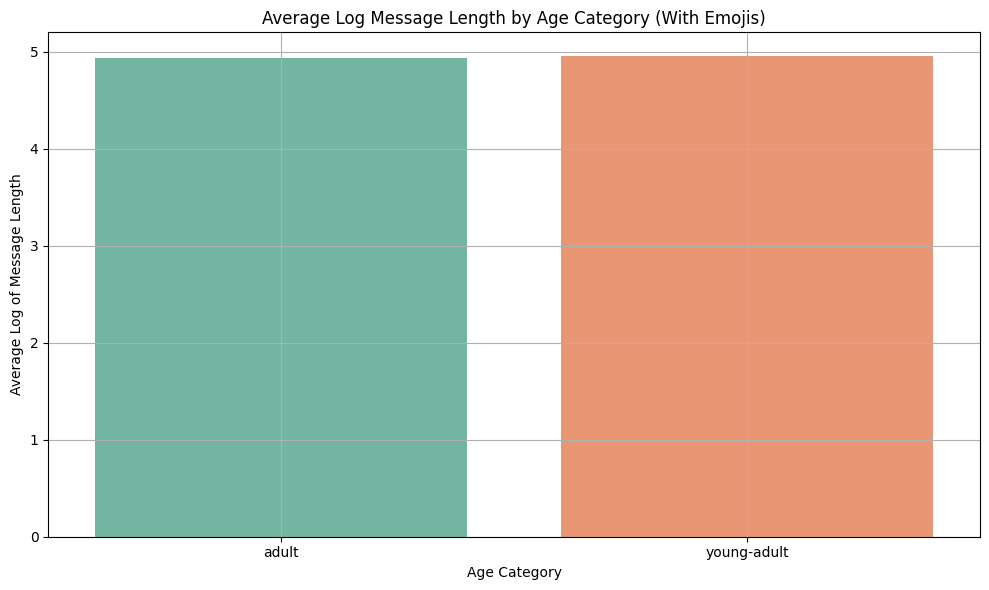

In [16]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Sample DataFrame setup
data = {
    'author': ['effervescent-camel', 'hilarious-goldfinch', 'nimble-wombat', 'spangled-rabbit'],
    'message_length': [100, 150, 200, 130],
    'has_emoji': [1, 0, 1, 0],
    'count': [5, 10, 7, 2]
}

df = pd.DataFrame(data)

# Assign age categories to each author
category_mapping = {
    'effervescent-camel': 'young-adult',
    'hilarious-goldfinch': 'adult',
    'nimble-wombat': 'young-adult',
    'spangled-rabbit': 'adult'
}

# Create a column for age category
df['age_category'] = df['author'].map(category_mapping)

# Calculate the logarithm of message length
df['log_len'] = np.log(df['message_length'])

# Create a new column to categorize messages based on emoji presence
df['emoji_status'] = df['has_emoji'].apply(lambda x: 'With Emoji' if x > 0 else 'Without Emoji')

# Filter the DataFrame for messages with emojis
df_with_emojis = df[df['emoji_status'] == 'With Emoji']

# Step 1: Group by age category and calculate mean log_len
mean_lengths = df.groupby('age_category')['log_len'].mean().reset_index()

# Step 2: Create the bar plot
plt.figure(figsize=(10, 6))
sns.barplot(data=mean_lengths, x='age_category', y='log_len', palette='Set2')
plt.title('Average Log Message Length by Age Category (With Emojis)')
plt.xlabel('Age Category')
plt.ylabel('Average Log of Message Length')
plt.grid(True)
plt.tight_layout()

# Save the plot with an opaque background
plt.savefig('bar_plot_average_log_length.png', bbox_inches='tight', transparent=False)

# Show the plot
plt.show()



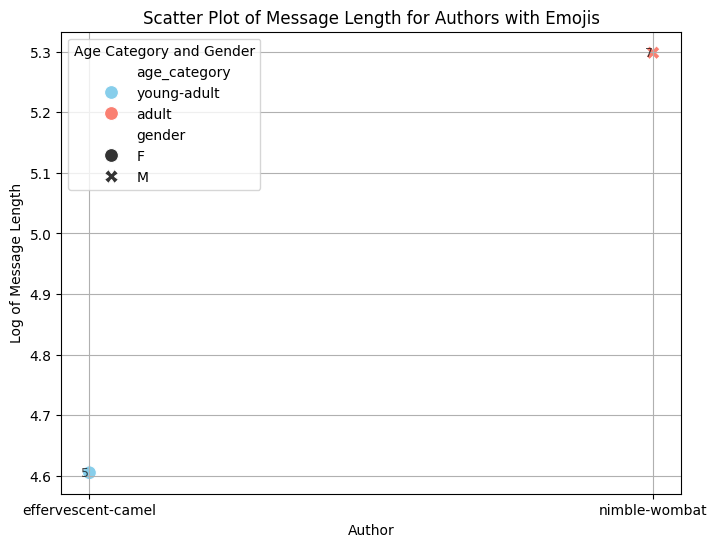

In [79]:
# Create the scatter plot
plt.figure(figsize=(8, 6), facecolor='white')  # Set facecolor to white
sns.scatterplot(data=df_with_emojis, x='author', y='log_len', hue='age_category', style='gender', s=100, 
                palette={'young-adult': 'skyblue', 'adult': 'salmon'})

# Add count annotations
for i in range(df_with_emojis.shape[0]):
    plt.text(df_with_emojis['author'].iloc[i], df_with_emojis['log_len'].iloc[i], 
             df_with_emojis['count'].iloc[i], fontsize=9, ha='right', va='center', alpha=0.7)

# Add titles and labels
plt.title('Scatter Plot of Message Length for Authors with Emojis')
plt.xlabel('Author')
plt.ylabel('Log of Message Length')
plt.grid(True)
plt.legend(title='Age Category and Gender')

# Save the plot
#plt.savefig('scatter_plot_with_emojis.png', bbox_inches='tight', transparent=False)  # Ensure background is not transparent

# Show the plot
plt.show()

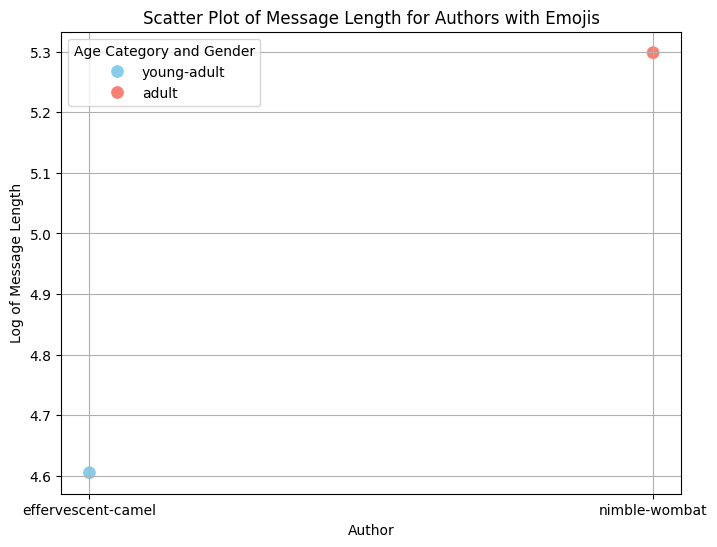

In [18]:
# Assign genders and age categories to each author
category_mapping = {
    'effervescent-camel': ('F', 'young-adult'),
    'hilarious-goldfinch': ('F', 'adult'),
    'nimble-wombat': ('M', 'adult'),
    'spangled-rabbit': ('M', 'young-adult')
}

# Create separate columns for gender and age category
df['gender'], df['age_category'] = zip(*df['author'].map(category_mapping))

# Calculate the logarithm of message length
df['log_len'] = np.log(df['message_length'])

# Create a new column to categorize messages based on emoji presence
df['emoji_status'] = df['has_emoji'].apply(lambda x: 'With Emoji' if x > 0 else 'Without Emoji')

# Filter the DataFrame for messages with emojis
df_with_emojis = df[df['emoji_status'] == 'With Emoji']

# Create the scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_with_emojis, x='author', y='log_len', hue='age_category',  s=100, palette={'young-adult': 'skyblue', 'adult': 'salmon'})



# Add titles and labels
plt.title('Scatter Plot of Message Length for Authors with Emojis')
plt.xlabel('Author')
plt.ylabel('Log of Message Length')
plt.grid(True)
plt.legend(title='Age Category and Gender')
plt.show()

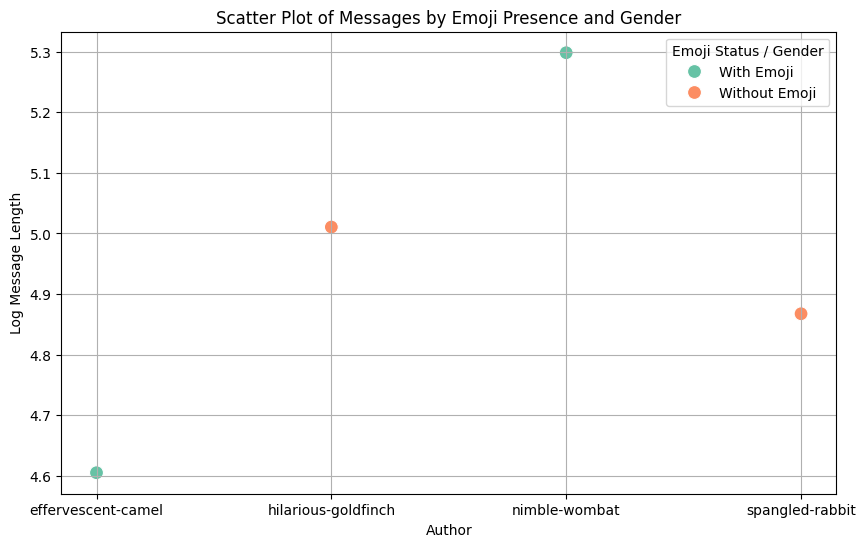

In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt




# Assign genders to each author
gender_mapping = {
    'effervescent-camel': 'F',
    'hilarious-goldfinch': 'F',
    'nimble-wombat': 'M',
    'spangled-rabbit': 'M'
}

df['gender'] = df['author'].map(gender_mapping)

# Create a new column to categorize messages based on emoji presence
df['emoji_status'] = df['has_emoji'].apply(lambda x: 'With Emoji' if x > 0 else 'Without Emoji')

# Create the scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='author', y='log_len', hue='emoji_status', palette='Set2', s=100)

plt.title('Scatter Plot of Messages by Emoji Presence and Gender')
plt.xlabel('Author')
plt.ylabel('Log Message Length')
plt.legend(title='Emoji Status / Gender')
plt.grid(True)
plt.show()


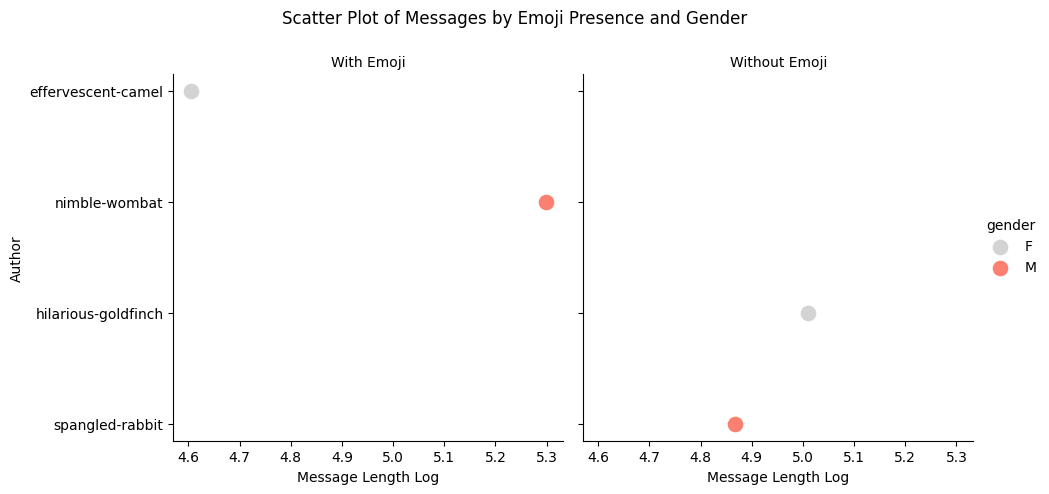

In [20]:
df['gender'] = df['author'].map(gender_mapping)

# Create a new column to categorize messages based on emoji presence
df['emoji_status'] = df['has_emoji'].apply(lambda x: 'With Emoji' if x > 0 else 'Without Emoji')

# Create a color palette
custom_palette = {'F': 'lightgray', 'M': 'salmon'}

# Create the FacetGrid
g = sns.FacetGrid(df, col='emoji_status', hue='gender', height=5, aspect=1, palette=custom_palette)


# Map the scatter plot to each facet
g.map(sns.scatterplot, 'log_len', 'author', s=150)
g.add_legend()

# Add titles and labels
g.set_axis_labels('Message Length Log', 'Author')
g.set_titles(col_template='{col_name}')

plt.subplots_adjust(top=0.85)
g.fig.suptitle('Scatter Plot of Messages by Emoji Presence and Gender')
plt.show()

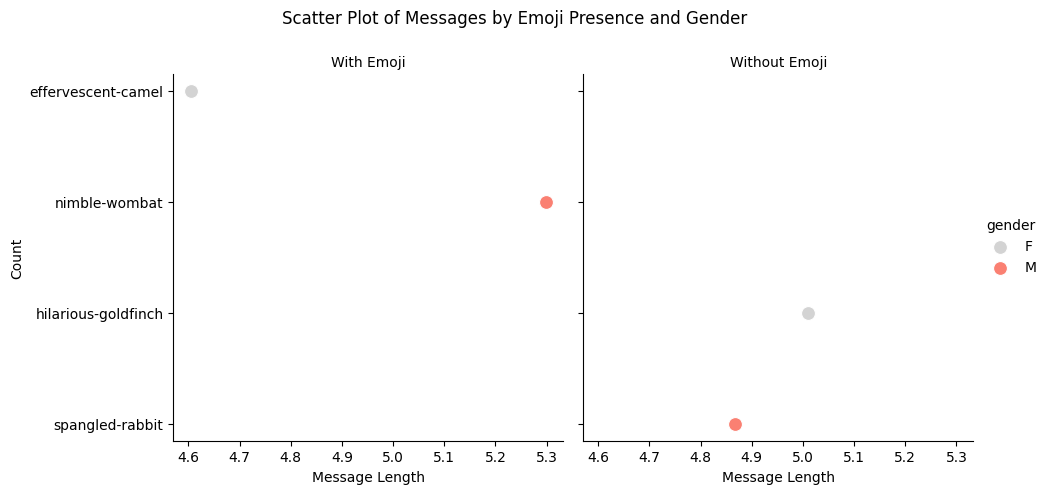

In [21]:
df['gender'] = df['author'].map(gender_mapping)

# Create a new column to categorize messages based on emoji presence
df['emoji_status'] = df['has_emoji'].apply(lambda x: 'With Emoji' if x > 0 else 'Without Emoji')

# Create a custom color palette for genders
gender_palette = {'F': 'skyblue', 'M': 'salmon'}


# Create the FacetGrid
g = sns.FacetGrid(df, col='emoji_status', hue='gender', height=5, aspect=1, palette=custom_palette)

# Map the scatter plot to each facet
g.map(sns.scatterplot, 'log_len', 'author', s=100)

# Add a legend
g.add_legend()

# Set titles and labels
g.set_axis_labels('Message Length', 'Count')
g.set_titles(col_template='{col_name}')




plt.subplots_adjust(top=0.85)
g.fig.suptitle('Scatter Plot of Messages by Emoji Presence and Gender')
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

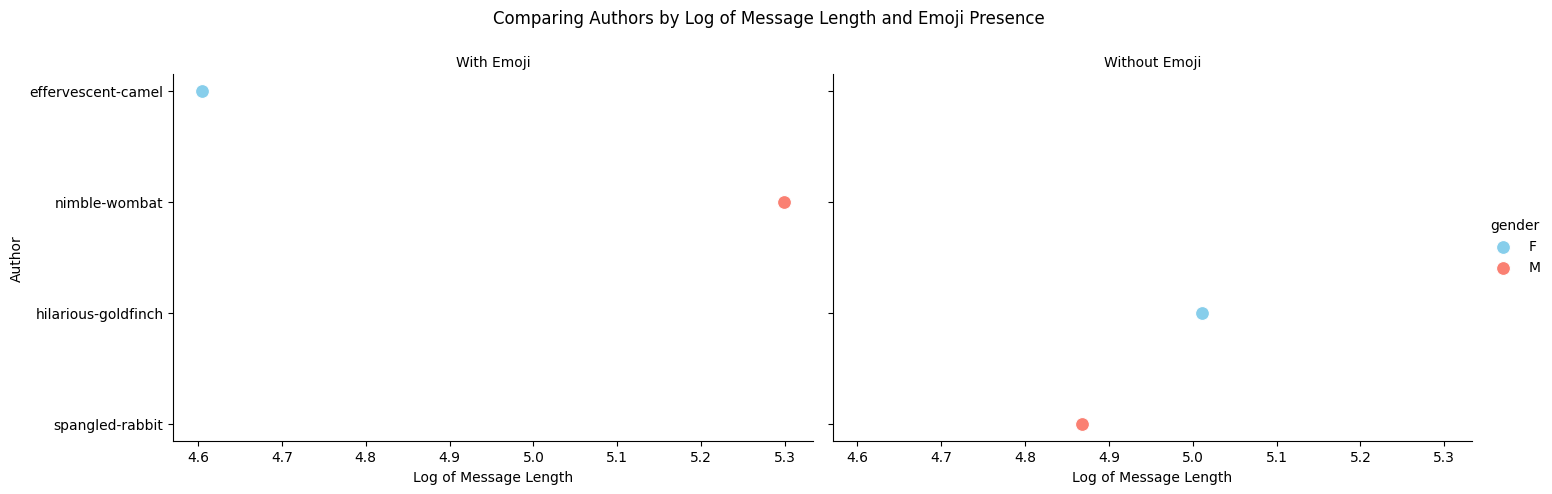

In [22]:
# Create a new column to categorize messages based on emoji presence
df['emoji_status'] = df['has_emoji'].apply(lambda x: 'With Emoji' if x > 0 else 'Without Emoji')

# Create a FacetGrid
g = sns.FacetGrid(df, col='emoji_status', hue='gender', height=5, aspect=1.5, palette={'F': 'skyblue', 'M': 'salmon'})

# Map the scatter plot to each facet
g.map(sns.scatterplot, 'log_len', 'author', s=100)

# Add titles and labels
g.set_axis_labels('Log of Message Length', 'Author')
g.set_titles(col_template='{col_name}')

# Add a legend
g.add_legend()

# Adjust layout
plt.subplots_adjust(top=0.85)
g.fig.suptitle('Comparing Authors by Log of Message Length and Emoji Presence')
plt.show

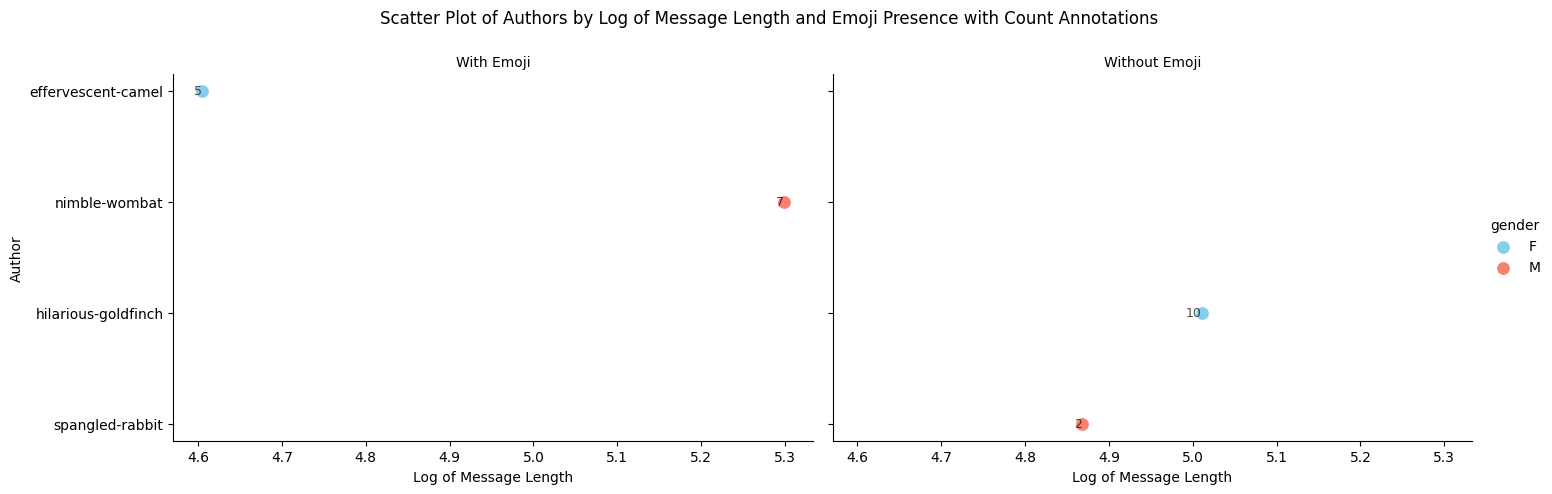

In [23]:
# Create a FacetGrid
g = sns.FacetGrid(df, col='emoji_status', hue='gender', height=5, aspect=1.5, palette={'F': 'skyblue', 'M': 'salmon'})

# Map the scatter plot to each facet
g.map(sns.scatterplot, 'log_len', 'author', s=100)



# Add count annotations
for ax in g.axes.flat:
    for i in range(df.shape[0]):
        # Get the correct axis based on emoji status
        if df['emoji_status'][i] in ax.get_title():
            ax.text(df['log_len'][i], df['author'][i], df['count'][i], 
                    fontsize=9, ha='right', va='center', alpha=0.7)

# Add titles and labels
g.set_axis_labels('Log of Message Length', 'Author')
g.set_titles(col_template='{col_name}')

# Add a legend
g.add_legend()

# Adjust layout
plt.subplots_adjust(top=0.85)
g.fig.suptitle('Scatter Plot of Authors by Log of Message Length and Emoji Presence with Count Annotations')
plt.show()

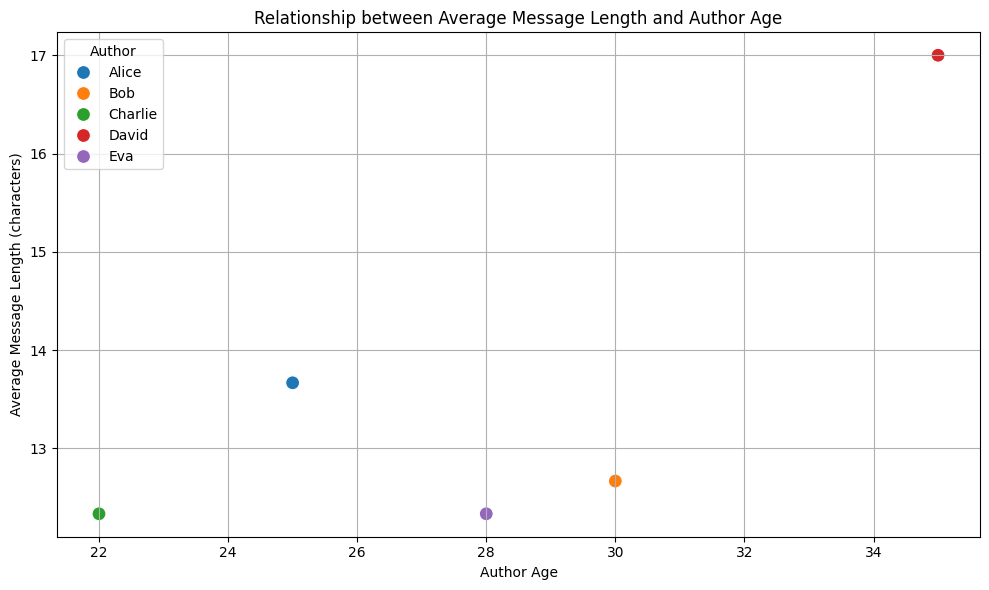

In [31]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Sample data: a list of authors with their ages and messages
data2 = {
    'author': ['Alice', 'Bob', 'Charlie', 'David', 'Eva'],
    'age': [25, 30, 22, 35, 28],
    'messages': [
        ["Hello!", "How are you doing?", "Nice to meet you!"],
        ["Hey there!", "What's up?", "Let's grab coffee!"],
        ["Hi!", "Just checking in.", "Have a great day!"],
        ["Greetings!", "Looking forward to the meeting.", "Take care!"],
        ["Hello!", "What do you think?", "See you soon!"]
    ]
}

# Step 1: Create a DataFrame
df2 = pd.DataFrame(data2)

# Step 2: Calculate average message length for each author
df2['avg_length'] = df2['messages'].apply(lambda messages: sum(len(msg) for msg in messages) / len(messages))

# Step 3: Plot the relationship
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df2, x='age', y='avg_length', hue='author', s=100)
plt.title('Relationship between Average Message Length and Author Age')
plt.xlabel('Author Age')
plt.ylabel('Average Message Length (characters)')
plt.legend(title='Author')
plt.grid(True)
plt.tight_layout()
plt.show()


Lowess stands for Locally Weighted Scatterplot Smoothing, and it is a non-parametric regression method that fits a smooth curve to the data. It is a useful tool to explore the relationship between two variables, but it is not a model in the traditional sense. It is a tool to help us understand the data, not to make predictions.

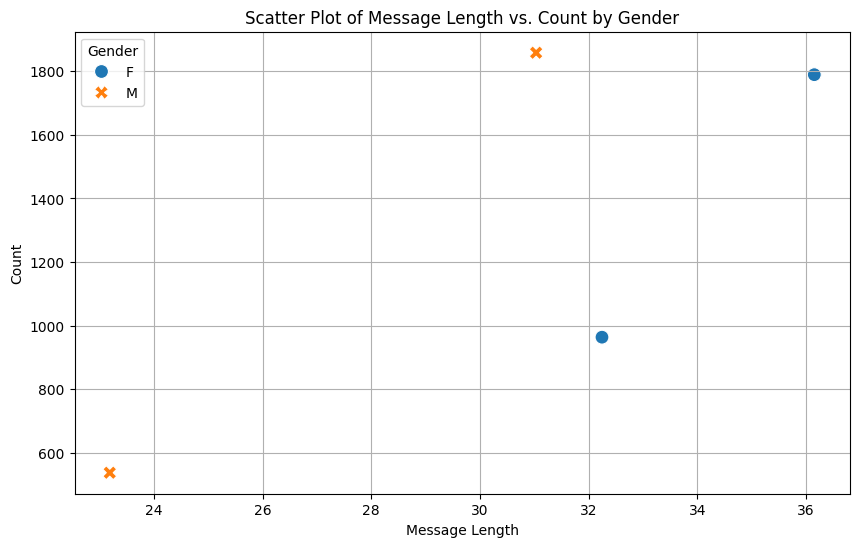

In [21]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Sample data
data = {
    'author': ['effervescent-camel', 'hilarious-goldfinch', 'nimble-wombat', 'spangled-rabbit'],
    'message_length': [36.152040, 32.245851, 31.034446, 23.189591],
    'has_emoji': [0.038010, 0.085062, 0.141550, 0.011152],
    'count': [1789, 964, 1858, 538]
}

# Create DataFrame
df = pd.DataFrame(data)

# Assign genders to each author
gender_mapping = {
    'effervescent-camel': 'F',
    'hilarious-goldfinch': 'F',
    'nimble-wombat': 'M',
    'spangled-rabbit': 'M'
}

df['gender'] = df['author'].map(gender_mapping)

# Create the scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='message_length', y='count', hue='gender', style='gender', s=100)

plt.title('Scatter Plot of Message Length vs. Count by Gender')
plt.xlabel('Message Length')
plt.ylabel('Count')
plt.legend(title='Gender')
plt.grid(True)
plt.show()


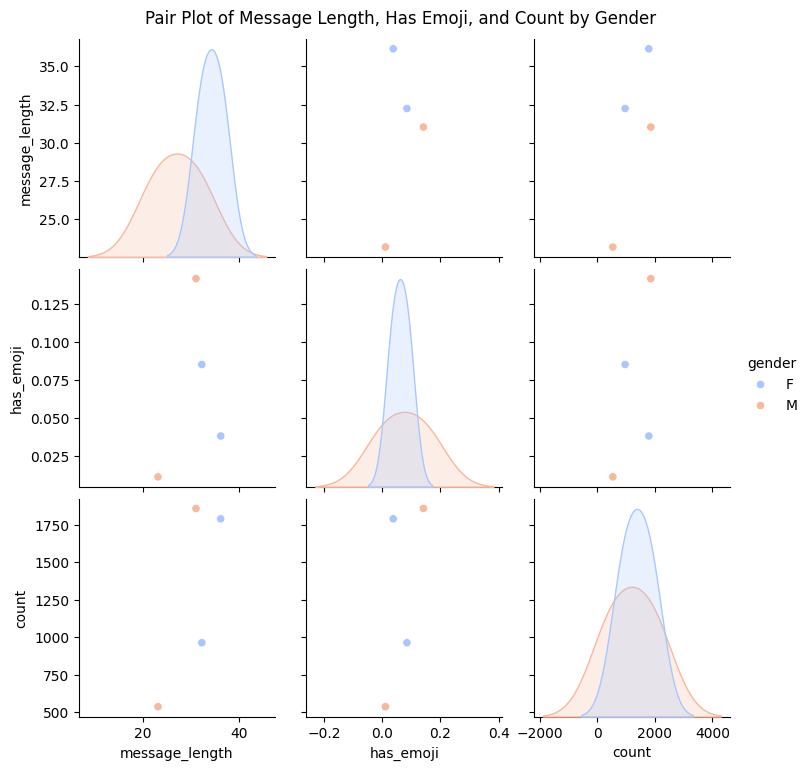

In [22]:
# Select only relevant columns for pair plot
sns.pairplot(df, hue='gender', vars=['message_length', 'has_emoji', 'count'], palette='coolwarm')
plt.suptitle('Pair Plot of Message Length, Has Emoji, and Count by Gender', y=1.02)
plt.show()

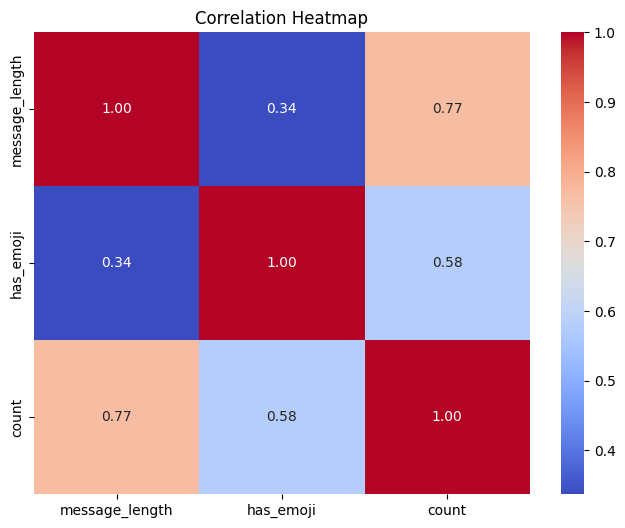

In [24]:
# Calculate the correlation matrix using only numeric columns
correlation_matrix = df[['message_length', 'has_emoji', 'count']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()



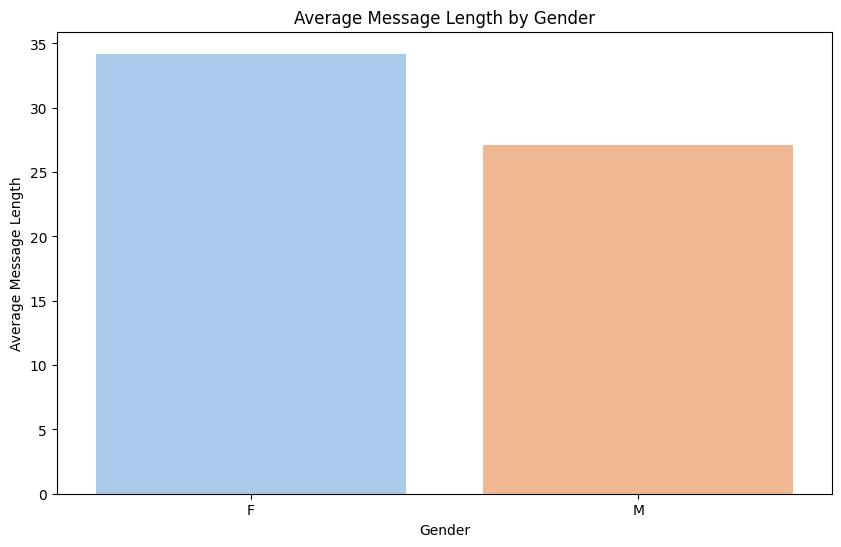

In [25]:
# Calculate average message length and count by gender
avg_df = df.groupby('gender').agg({'message_length': 'mean', 'count': 'mean'}).reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(data=avg_df, x='gender', y='message_length', palette='pastel')
plt.title('Average Message Length by Gender')
plt.xlabel('Gender')
plt.ylabel('Average Message Length')
plt.show()


In [1]:
profiel = {'Achternaam': 'Krstic', 'Naam': 'Milan Krstic', 'Leeftijd': 22, 'Geslacht': 'man', 'Geboortedatum': '12/03/2000', 'Address': 'Bogdanovića 34, Novi Knezevac', 'Hobbies': 'Wandelen in de bergen, hondentraining', 'Werk': 'Student, Universiteit van Novi Knezevac, 2 jaar', 'Talen': 'Servisch, Engels', 'Fun-fact': 'Hij is een fervent bergbeklimmer en houdt van het trainen van zijn hond.', 'Email': 'milan.krstic@proton.me', 'Extra': 'Hij heeft een hond genaamd Max en houdt van het eten van traditionele Servische gerechten.', 'Story': 'Milan Krstic is een 22-jarige man, geboren op 12 maart 2000. Hij studeert aan de Universiteit van Novi Knezevac en is een fervent bergbeklimmer. Hij houdt van het trainen van zijn hond Max en geniet van traditionele Servische gerechten. Hij spreekt Servisch en Engels.', 'Description': 'Milan Krstic is een 22-jarige man, geboren op 12 maart 2000. Hij studeert aan de Universiteit van Novi Knezevac en is een fervent bergbeklimmer. Hij houdt van het trainen van zijn hond Max en geniet van traditionele Servische gerechten. Hij spreekt Servisch en Engels. Hij woont in Novi Knezevac, Servië. Hij is een student en studeert al 2 jaar aan de Universiteit van Novi Knezevac. Hij houdt van wandelen in de bergen en hondentraining. Hij is een fervent bergbeklimmer en houdt van het trainen van zijn hond. Hij heeft een hond genaamd Max en houdt van het eten van traditionele Servische gerechten. Zijn email is milan.krstic@proton.me.'}

In [23]:
import pandas as pd
df = pd.DataFrame(profiel, index=[0]).T

In [25]:
df.columns= ["Persoon info"]

In [37]:
html_table = df.to_html(index=True, border=3, header=True, col_space= 200, notebook=True, justify='left')

In [38]:
html_table

'<div>\n<style scoped>\n    .dataframe tbody tr th:only-of-type {\n        vertical-align: middle;\n    }\n\n    .dataframe tbody tr th {\n        vertical-align: top;\n    }\n\n    .dataframe thead th {\n        text-align: right;\n    }\n</style>\n<table border="3" class="dataframe">\n  <thead>\n    <tr style="text-align: left;">\n      <th style="min-width: 200px;"></th>\n      <th style="min-width: 200px;">Persoon info</th>\n    </tr>\n  </thead>\n  <tbody>\n    <tr>\n      <th>Achternaam</th>\n      <td>Krstic</td>\n    </tr>\n    <tr>\n      <th>Naam</th>\n      <td>Milan Krstic</td>\n    </tr>\n    <tr>\n      <th>Leeftijd</th>\n      <td>22</td>\n    </tr>\n    <tr>\n      <th>Geslacht</th>\n      <td>man</td>\n    </tr>\n    <tr>\n      <th>Geboortedatum</th>\n      <td>12/03/2000</td>\n    </tr>\n    <tr>\n      <th>Address</th>\n      <td>Bogdanovića 34, Novi Knezevac</td>\n    </tr>\n    <tr>\n      <th>Hobbies</th>\n      <td>Wandelen in de bergen, hondentraining</td>\n   

<html><div>\n<style scoped>\n    .dataframe tbody tr th:only-of-type {\n        vertical-align: middle;\n    }\n\n    .dataframe tbody tr th {\n        vertical-align: top;\n    }\n\n    .dataframe thead th {\n        text-align: right;\n    }\n</style>\n<table border="3" class="dataframe">\n  <thead>\n    <tr style="text-align: left;">\n      <th style="min-width: 200px;"></th>\n      <th style="min-width: 200px;">Persoon info</th>\n    </tr>\n  </thead>\n  <tbody>\n    <tr>\n      <th>Achternaam</th>\n      <td>Krstic</td>\n    </tr>\n    <tr>\n      <th>Naam</th>\n      <td>Milan Krstic</td>\n    </tr>\n    <tr>\n      <th>Leeftijd</th>\n      <td>22</td>\n    </tr>\n    <tr>\n      <th>Geslacht</th>\n      <td>man</td>\n    </tr>\n    <tr>\n      <th>Geboortedatum</th>\n      <td>12/03/2000</td>\n    </tr>\n    <tr>\n      <th>Address</th>\n      <td>Bogdanovića 34, Novi Knezevac</td>\n    </tr>\n    <tr>\n      <th>Hobbies</th>\n      <td>Wandelen in de bergen, hondentraining</td>\n    </tr>\n    <tr>\n      <th>Werk</th>\n      <td>Student, Universiteit van Novi Knezevac, 2 jaar</td>\n    </tr>\n    <tr>\n      <th>Talen</th>\n      <td>Servisch, Engels</td>\n    </tr>\n    <tr>\n      <th>Fun-fact</th>\n      <td>Hij is een fervent bergbeklimmer en houdt van ...</td>\n    </tr>\n    <tr>\n      <th>Email</th>\n      <td>milan.krstic@proton.me</td>\n    </tr>\n    <tr>\n      <th>Extra</th>\n      <td>Hij heeft een hond genaamd Max en houdt van he...</td>\n    </tr>\n    <tr>\n      <th>Story</th>\n      <td>Milan Krstic is een 22-jarige man, geboren op ...</td>\n    </tr>\n    <tr>\n      <th>Description</th>\n      <td>Milan Krstic is een 22-jarige man, geboren op ...</td>\n    </tr>\n  </tbody>\n</table>\n</div></html>